# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-kmeans'
epochs = 10
batch_size = 32
sequence_length = 64

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [10]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [11]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [12]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [13]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [14]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [16]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [18]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    collected_indices = set()  # Initialize set to store selected indices

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        num_of_candidates = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        # Determine number of clusters
        if num_of_candidates <= n_clusters and n_clusters < nearest_cp - current_train_size:
            n_clusters = n_clusters
        elif num_of_candidates > n_clusters and num_of_candidates < nearest_cp - current_train_size:
            n_clusters = num_of_candidates
        else:
            arrived_at_cp = True
            n_clusters = nearest_cp - current_train_size
            
        kmeans=KMeans(n_clusters=n_clusters, n_init=1)
        kmeans.fit(embeddings)
    
        if current_train_size > checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]  # Indices of samples in the current cluster
                
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances to the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
                closest_sample_index = cluster_indices[np.argmin(cluster_distances)]  # Closest sample index
                collected_indices.add(closest_sample_index)

            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5523, Accuracy: 0.8278, F1 Micro: 0.0483, F1 Macro: 0.017
Epoch 2/10, Train Loss: 0.4112, Accuracy: 0.8287, F1 Micro: 0.0251, F1 Macro: 0.0109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3817, Accuracy: 0.8313, F1 Micro: 0.0562, F1 Macro: 0.023
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3552, Accuracy: 0.8534, F1 Micro: 0.3322, F1 Macro: 0.1087
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3425, Accuracy: 0.8667, F1 Micro: 0.4499, F1 Macro: 0.1904
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3131, Accuracy: 0.8731, F1 Micro: 0.6036, F1 Macro: 0.2896
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2691, Accuracy: 0.8766, F1 Micro: 0.6219, F1 Macro: 0.3077
Epoch 8/10, Train Loss: 0.2634, Accuracy: 0.8822, F1 Micro: 0.5944, F1 Macro: 0.2945
Epoch 9/10, Train Loss: 0.2253, Accuracy: 0.8804, F1 Micro: 0.5629, F1 Macro: 0.2872
Epoch 10/10, Train Loss: 0.1952, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4675, Accuracy: 0.8288, F1 Micro: 0.024, F1 Macro: 0.0105
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3568, Accuracy: 0.8562, F1 Micro: 0.3464, F1 Macro: 0.1228
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3035, Accuracy: 0.8817, F1 Micro: 0.6036, F1 Macro: 0.2899
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.255, Accuracy: 0.8879, F1 Micro: 0.6166, F1 Macro: 0.3112
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2117, Accuracy: 0.8928, F1 Micro: 0.6487, F1 Macro: 0.347
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1824, Accuracy: 0.8932, F1 Micro: 0.6715, F1 Macro: 0.3822
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1606, Accuracy: 0.9003, F1 Micro: 0.6755, F1 Macro: 0.4529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1399, Accuracy: 0.8965, F1 Micro: 0.7109, F1 Macro: 0.4858
Epoch 9/10, Train Loss: 0.1208, Accuracy: 0.8985, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.437, Accuracy: 0.8355, F1 Micro: 0.1112, F1 Macro: 0.0401
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3373, Accuracy: 0.882, F1 Micro: 0.6039, F1 Macro: 0.2819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2723, Accuracy: 0.893, F1 Micro: 0.6399, F1 Macro: 0.3217
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.226, Accuracy: 0.9008, F1 Micro: 0.6913, F1 Macro: 0.4604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1899, Accuracy: 0.9035, F1 Micro: 0.6949, F1 Macro: 0.4604
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1581, Accuracy: 0.9053, F1 Micro: 0.7273, F1 Macro: 0.5589
Epoch 7/10, Train Loss: 0.1273, Accuracy: 0.9083, F1 Micro: 0.7174, F1 Macro: 0.5348
Epoch 8/10, Train Loss: 0.1113, Accuracy: 0.9065, F1 Micro: 0.7174, F1 Macro: 0.5337
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0902, Accuracy: 0.9058, F1 Micro: 0.7327, F1 Macro: 0.5628
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.42, Accuracy: 0.8634, F1 Micro: 0.4281, F1 Macro: 0.159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3127, Accuracy: 0.8913, F1 Micro: 0.6206, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2515, Accuracy: 0.9055, F1 Micro: 0.7063, F1 Macro: 0.5185
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2052, Accuracy: 0.9091, F1 Micro: 0.7222, F1 Macro: 0.5231
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1702, Accuracy: 0.9115, F1 Micro: 0.7378, F1 Macro: 0.5624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.913, F1 Micro: 0.7405, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1173, Accuracy: 0.9117, F1 Micro: 0.7488, F1 Macro: 0.5994
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9135, F1 Micro: 0.7411, F1 Macro: 0.5982
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9133, F1 Micro: 0.7375, F1 Macro: 0.6142
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4176, Accuracy: 0.8784, F1 Micro: 0.6087, F1 Macro: 0.3028
Epoch 2/10, Train Loss: 0.2946, Accuracy: 0.8916, F1 Micro: 0.6076, F1 Macro: 0.3316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2403, Accuracy: 0.9038, F1 Micro: 0.6973, F1 Macro: 0.4629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2008, Accuracy: 0.9118, F1 Micro: 0.7362, F1 Macro: 0.5597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1629, Accuracy: 0.9119, F1 Micro: 0.7474, F1 Macro: 0.5969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1308, Accuracy: 0.9158, F1 Micro: 0.7541, F1 Macro: 0.6184
Epoch 7/10, Train Loss: 0.1118, Accuracy: 0.9169, F1 Micro: 0.751, F1 Macro: 0.6227
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.915, F1 Micro: 0.7498, F1 Macro: 0.6287
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.9121, F1 Micro: 0.756, F1 Macro: 0.6272
Epoch 10/10, Train Loss: 0.0631, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.414, Accuracy: 0.8832, F1 Micro: 0.586, F1 Macro: 0.2958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2871, Accuracy: 0.9047, F1 Micro: 0.7025, F1 Macro: 0.4951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.231, Accuracy: 0.9121, F1 Micro: 0.7392, F1 Macro: 0.5508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1858, Accuracy: 0.9119, F1 Micro: 0.7482, F1 Macro: 0.5804
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9192, F1 Micro: 0.7522, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1233, Accuracy: 0.917, F1 Micro: 0.7568, F1 Macro: 0.6284
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9199, F1 Micro: 0.7596, F1 Macro: 0.6422
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.9198, F1 Micro: 0.7618, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.407, Accuracy: 0.8875, F1 Micro: 0.6558, F1 Macro: 0.3478
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2835, Accuracy: 0.9079, F1 Micro: 0.7089, F1 Macro: 0.5232
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2244, Accuracy: 0.9137, F1 Micro: 0.7345, F1 Macro: 0.5749
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1898, Accuracy: 0.9184, F1 Micro: 0.7539, F1 Macro: 0.6051
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1508, Accuracy: 0.9169, F1 Micro: 0.7621, F1 Macro: 0.6333
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9185, F1 Micro: 0.7599, F1 Macro: 0.6334
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9212, F1 Micro: 0.7634, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9222, F1 Micro: 0.7673, F1 Macro: 0.653
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9203, F1 Micro: 0.7661, F1 Macro: 0.6774
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3993, Accuracy: 0.8878, F1 Micro: 0.5869, F1 Macro: 0.3114
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2816, Accuracy: 0.9058, F1 Micro: 0.7282, F1 Macro: 0.5463
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.225, Accuracy: 0.9166, F1 Micro: 0.7527, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.919, F1 Micro: 0.7607, F1 Macro: 0.6216
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.9216, F1 Micro: 0.7572, F1 Macro: 0.6148
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9216, F1 Micro: 0.7679, F1 Macro: 0.6276
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.9183, F1 Micro: 0.7669, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9171, F1 Micro: 0.7697, F1 Macro: 0.6798
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9191, F1 Micro: 0.7692, F1 Macro: 0.6959
Epoch 10/10, Train Loss: 0.0575, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3938, Accuracy: 0.8947, F1 Micro: 0.6557, F1 Macro: 0.3752
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.911, F1 Micro: 0.7456, F1 Macro: 0.5683
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.9166, F1 Micro: 0.7589, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1742, Accuracy: 0.9223, F1 Micro: 0.7619, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9207, F1 Micro: 0.7681, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9201, F1 Micro: 0.7685, F1 Macro: 0.6613
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.9209, F1 Micro: 0.7703, F1 Macro: 0.6613
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.9225, F1 Micro: 0.7595, F1 Macro: 0.6697
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.923, F1 Micro: 0.7635, F1 Macro: 0.6955
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3865, Accuracy: 0.8959, F1 Micro: 0.6639, F1 Macro: 0.4055
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2674, Accuracy: 0.9118, F1 Micro: 0.7225, F1 Macro: 0.5145
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2101, Accuracy: 0.9133, F1 Micro: 0.7237, F1 Macro: 0.5811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.9208, F1 Micro: 0.7639, F1 Macro: 0.6274
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9242, F1 Micro: 0.7706, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.9217, F1 Micro: 0.7747, F1 Macro: 0.6786
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0942, Accuracy: 0.9242, F1 Micro: 0.779, F1 Macro: 0.6944
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9234, F1 Micro: 0.7716, F1 Macro: 0.6913
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.9201, F1 Micro: 0.7721, F1 Macro: 0.7046
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3794, Accuracy: 0.8992, F1 Micro: 0.6938, F1 Macro: 0.468
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.9138, F1 Micro: 0.7337, F1 Macro: 0.5634
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.92, F1 Micro: 0.7644, F1 Macro: 0.6194
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9235, F1 Micro: 0.7726, F1 Macro: 0.6416
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9255, F1 Micro: 0.777, F1 Macro: 0.6659
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9202, F1 Micro: 0.77, F1 Macro: 0.6715
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9234, F1 Micro: 0.7689, F1 Macro: 0.6773
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9229, F1 Micro: 0.777, F1 Macro: 0.6817
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.9255, F1 Micro: 0.7803, F1 Macro: 0.7124
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3832, Accuracy: 0.896, F1 Micro: 0.6541, F1 Macro: 0.3634
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.9143, F1 Micro: 0.7436, F1 Macro: 0.5563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2122, Accuracy: 0.9214, F1 Micro: 0.754, F1 Macro: 0.5835
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.9246, F1 Micro: 0.7703, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9262, F1 Micro: 0.7708, F1 Macro: 0.6606
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1103, Accuracy: 0.926, F1 Micro: 0.7847, F1 Macro: 0.6953
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9266, F1 Micro: 0.7817, F1 Macro: 0.6961
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9273, F1 Micro: 0.7862, F1 Macro: 0.7151
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.927, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.378, Accuracy: 0.9021, F1 Micro: 0.6896, F1 Macro: 0.4185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2628, Accuracy: 0.9184, F1 Micro: 0.7432, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2078, Accuracy: 0.9206, F1 Micro: 0.7679, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9259, F1 Micro: 0.7752, F1 Macro: 0.6587
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.9277, F1 Micro: 0.787, F1 Macro: 0.671
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.9204, F1 Micro: 0.7726, F1 Macro: 0.6699
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9276, F1 Micro: 0.7876, F1 Macro: 0.7015
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9286, F1 Micro: 0.7872, F1 Macro: 0.7087
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9266, F1 Micro: 0.7838, F1 Macro: 0.7198
Epoch 10/10, Train Loss: 0.0479, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3772, Accuracy: 0.9018, F1 Micro: 0.706, F1 Macro: 0.4619
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.9178, F1 Micro: 0.7477, F1 Macro: 0.5765
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9224, F1 Micro: 0.7586, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.925, F1 Micro: 0.7781, F1 Macro: 0.6472
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.924, F1 Micro: 0.7814, F1 Macro: 0.6632
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9268, F1 Micro: 0.7749, F1 Macro: 0.6938
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9262, F1 Micro: 0.7786, F1 Macro: 0.7065
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9239, F1 Micro: 0.7749, F1 Macro: 0.7195
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.9251, F1 Micro: 0.7776, F1 Macro: 0.7103
Epoch 10/10, Train Loss: 0.0499, Accuracy: 0.9263, F1 Micro: 0.781, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3711, Accuracy: 0.9036, F1 Micro: 0.6963, F1 Macro: 0.4561
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.9166, F1 Micro: 0.7411, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.9217, F1 Micro: 0.7759, F1 Macro: 0.628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9247, F1 Micro: 0.7777, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9249, F1 Micro: 0.7718, F1 Macro: 0.6722
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.9257, F1 Micro: 0.7758, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9254, F1 Micro: 0.7796, F1 Macro: 0.7026
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9275, F1 Micro: 0.7787, F1 Macro: 0.7089
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9263, F1 Micro: 0.7808, F1 Macro: 0.7253
Epoch 10/10, Train Loss: 0.0478, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3697, Accuracy: 0.904, F1 Micro: 0.702, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2501, Accuracy: 0.9174, F1 Micro: 0.7554, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9188, F1 Micro: 0.7587, F1 Macro: 0.5901
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9193, F1 Micro: 0.7718, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9272, F1 Micro: 0.7843, F1 Macro: 0.6753
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.925, F1 Micro: 0.7819, F1 Macro: 0.6939
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.927, F1 Micro: 0.7861, F1 Macro: 0.7207
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9265, F1 Micro: 0.7851, F1 Macro: 0.7183
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9224, F1 Micro: 0.7752, F1 Macro: 0.7115
Epoch 10/10, Train Loss: 0.0504, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3666, Accuracy: 0.9014, F1 Micro: 0.666, F1 Macro: 0.4345
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.9157, F1 Micro: 0.757, F1 Macro: 0.5907
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.9243, F1 Micro: 0.772, F1 Macro: 0.6369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9255, F1 Micro: 0.7746, F1 Macro: 0.6671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9261, F1 Micro: 0.7754, F1 Macro: 0.6695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.9272, F1 Micro: 0.7844, F1 Macro: 0.7044
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9235, F1 Micro: 0.781, F1 Macro: 0.716
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9255, F1 Micro: 0.7765, F1 Macro: 0.7105
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9252, F1 Micro: 0.7711, F1 Macro: 0.7063
Epoch 10/10, Train Loss: 0.0473, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3631, Accuracy: 0.9031, F1 Micro: 0.6981, F1 Macro: 0.4998
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.9194, F1 Micro: 0.7536, F1 Macro: 0.5931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.9215, F1 Micro: 0.7723, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1603, Accuracy: 0.9272, F1 Micro: 0.7861, F1 Macro: 0.6878
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.928, F1 Micro: 0.7866, F1 Macro: 0.6985
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9257, F1 Micro: 0.7777, F1 Macro: 0.6917
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9282, F1 Micro: 0.7846, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9271, F1 Micro: 0.7895, F1 Macro: 0.7222
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9237, F1 Micro: 0.7814, F1 Macro: 0.7217
Epoch 10/10, Train Loss: 0.0508, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3593, Accuracy: 0.9055, F1 Micro: 0.6906, F1 Macro: 0.4918
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2366, Accuracy: 0.9209, F1 Micro: 0.756, F1 Macro: 0.5844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9227, F1 Micro: 0.7784, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9284, F1 Micro: 0.7818, F1 Macro: 0.6879
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9273, F1 Micro: 0.7873, F1 Macro: 0.6947
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9265, F1 Micro: 0.7868, F1 Macro: 0.6991
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9305, F1 Micro: 0.7929, F1 Macro: 0.7239
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9271, F1 Micro: 0.7823, F1 Macro: 0.7146
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.9287, F1 Micro: 0.7883, F1 Macro: 0.7233
Epoch 10/10, Train Loss: 0.047, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3572, Accuracy: 0.9062, F1 Micro: 0.693, F1 Macro: 0.4767
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2397, Accuracy: 0.9227, F1 Micro: 0.7553, F1 Macro: 0.5898
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1916, Accuracy: 0.9253, F1 Micro: 0.7777, F1 Macro: 0.6383
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9272, F1 Micro: 0.7899, F1 Macro: 0.689
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9256, F1 Micro: 0.7852, F1 Macro: 0.7062
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9262, F1 Micro: 0.7884, F1 Macro: 0.7185
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9275, F1 Micro: 0.7882, F1 Macro: 0.7232
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.928, F1 Micro: 0.7863, F1 Macro: 0.7248
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9272, F1 Micro: 0.7823, F1 Macro: 0.7187
Epoch 10/10, Train Loss: 0.0487, Accuracy: 0.9276, F1 Micro: 0.7847, F1 Macro: 0.7183

 Iteration 9216: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3592, Accuracy: 0.9062, F1 Micro: 0.7055, F1 Macro: 0.4757
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.241, Accuracy: 0.9213, F1 Micro: 0.7565, F1 Macro: 0.5979
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.9245, F1 Micro: 0.7681, F1 Macro: 0.6236
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9256, F1 Micro: 0.7836, F1 Macro: 0.6872
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9281, F1 Micro: 0.7862, F1 Macro: 0.6919
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9284, F1 Micro: 0.7838, F1 Macro: 0.6939
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9244, F1 Micro: 0.7867, F1 Macro: 0.723
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9269, F1 Micro: 0.7851, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9282, F1 Micro: 0.7893, F1 Macro: 0.7292
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.353, Accuracy: 0.9049, F1 Micro: 0.6989, F1 Macro: 0.5141
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2385, Accuracy: 0.9201, F1 Micro: 0.7613, F1 Macro: 0.5723
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1869, Accuracy: 0.9217, F1 Micro: 0.7638, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9249, F1 Micro: 0.7801, F1 Macro: 0.6675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.9279, F1 Micro: 0.7879, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.9267, F1 Micro: 0.7895, F1 Macro: 0.7087
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9248, F1 Micro: 0.7757, F1 Macro: 0.6993
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9254, F1 Micro: 0.7807, F1 Macro: 0.7126
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9263, F1 Micro: 0.7789, F1 Macro: 0.7143
Epoch 10/10, Train Loss: 0.0459, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3489, Accuracy: 0.8999, F1 Micro: 0.6953, F1 Macro: 0.4346
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2379, Accuracy: 0.9198, F1 Micro: 0.7613, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9271, F1 Micro: 0.7799, F1 Macro: 0.6403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1472, Accuracy: 0.9283, F1 Micro: 0.7877, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9292, F1 Micro: 0.7914, F1 Macro: 0.6982
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9257, F1 Micro: 0.7847, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.928, F1 Micro: 0.7934, F1 Macro: 0.7191
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9265, F1 Micro: 0.7873, F1 Macro: 0.7226
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9265, F1 Micro: 0.7914, F1 Macro: 0.7267
Epoch 10/10, Train Loss: 0.0469, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3426, Accuracy: 0.9028, F1 Micro: 0.6656, F1 Macro: 0.4733
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2251, Accuracy: 0.9211, F1 Micro: 0.7607, F1 Macro: 0.5951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1813, Accuracy: 0.9246, F1 Micro: 0.7817, F1 Macro: 0.6655
Epoch 4/10, Train Loss: 0.1455, Accuracy: 0.9275, F1 Micro: 0.7795, F1 Macro: 0.6619
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.927, F1 Micro: 0.784, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.9275, F1 Micro: 0.7878, F1 Macro: 0.7118
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.926, F1 Micro: 0.787, F1 Macro: 0.717
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9249, F1 Micro: 0.7861, F1 Macro: 0.7251
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.927, F1 Micro: 0.7866, F1 Macro: 0.7236
Epoch 10/10, Train Loss: 0.0433, Accuracy: 0.926, F1 Micro: 0.7718, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3415, Accuracy: 0.9052, F1 Micro: 0.6884, F1 Macro: 0.4758
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2274, Accuracy: 0.9183, F1 Micro: 0.755, F1 Macro: 0.5951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9236, F1 Micro: 0.7758, F1 Macro: 0.6425
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9305, F1 Micro: 0.7862, F1 Macro: 0.6878
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.928, F1 Micro: 0.7907, F1 Macro: 0.707
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9269, F1 Micro: 0.7858, F1 Macro: 0.7199
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9244, F1 Micro: 0.7855, F1 Macro: 0.7154
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9287, F1 Micro: 0.791, F1 Macro: 0.7169
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9253, F1 Micro: 0.7857, F1 Macro: 0.7229
Epoch 10/10, Train Loss: 0.0439, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3332, Accuracy: 0.9058, F1 Micro: 0.71, F1 Macro: 0.4714
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2224, Accuracy: 0.92, F1 Micro: 0.7594, F1 Macro: 0.6061
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1727, Accuracy: 0.9274, F1 Micro: 0.7797, F1 Macro: 0.6589
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1378, Accuracy: 0.9296, F1 Micro: 0.7934, F1 Macro: 0.6941
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9292, F1 Micro: 0.7927, F1 Macro: 0.7118
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.9281, F1 Micro: 0.7829, F1 Macro: 0.6942
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9286, F1 Micro: 0.7932, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.929, F1 Micro: 0.7947, F1 Macro: 0.7189
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9266, F1 Micro: 0.7922, F1 Macro: 0.7299
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.9274, F1 Micro: 0.7837, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3265, Accuracy: 0.9061, F1 Micro: 0.7, F1 Macro: 0.4449
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2205, Accuracy: 0.921, F1 Micro: 0.7512, F1 Macro: 0.5874
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1731, Accuracy: 0.9268, F1 Micro: 0.7794, F1 Macro: 0.6464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.9275, F1 Micro: 0.7838, F1 Macro: 0.6647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.9282, F1 Micro: 0.7941, F1 Macro: 0.6936
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9293, F1 Micro: 0.7947, F1 Macro: 0.7144
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9277, F1 Micro: 0.7846, F1 Macro: 0.7195
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.922, F1 Micro: 0.7852, F1 Macro: 0.7201
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.9238, F1 Micro: 0.7847, F1 Macro: 0.7182
Epoch 10/10, Train Loss: 0.0413, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3195, Accuracy: 0.9041, F1 Micro: 0.6841, F1 Macro: 0.448
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2155, Accuracy: 0.9208, F1 Micro: 0.7546, F1 Macro: 0.5625
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9169, F1 Micro: 0.7673, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1357, Accuracy: 0.9278, F1 Micro: 0.7844, F1 Macro: 0.663
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.9262, F1 Micro: 0.7842, F1 Macro: 0.7026
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9264, F1 Micro: 0.788, F1 Macro: 0.7114
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9253, F1 Micro: 0.7803, F1 Macro: 0.7091
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9271, F1 Micro: 0.7853, F1 Macro: 0.719
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.9267, F1 Micro: 0.7862, F1 Macro: 0.7221
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.9272, F1 Micro: 0.7826, F1 Macr

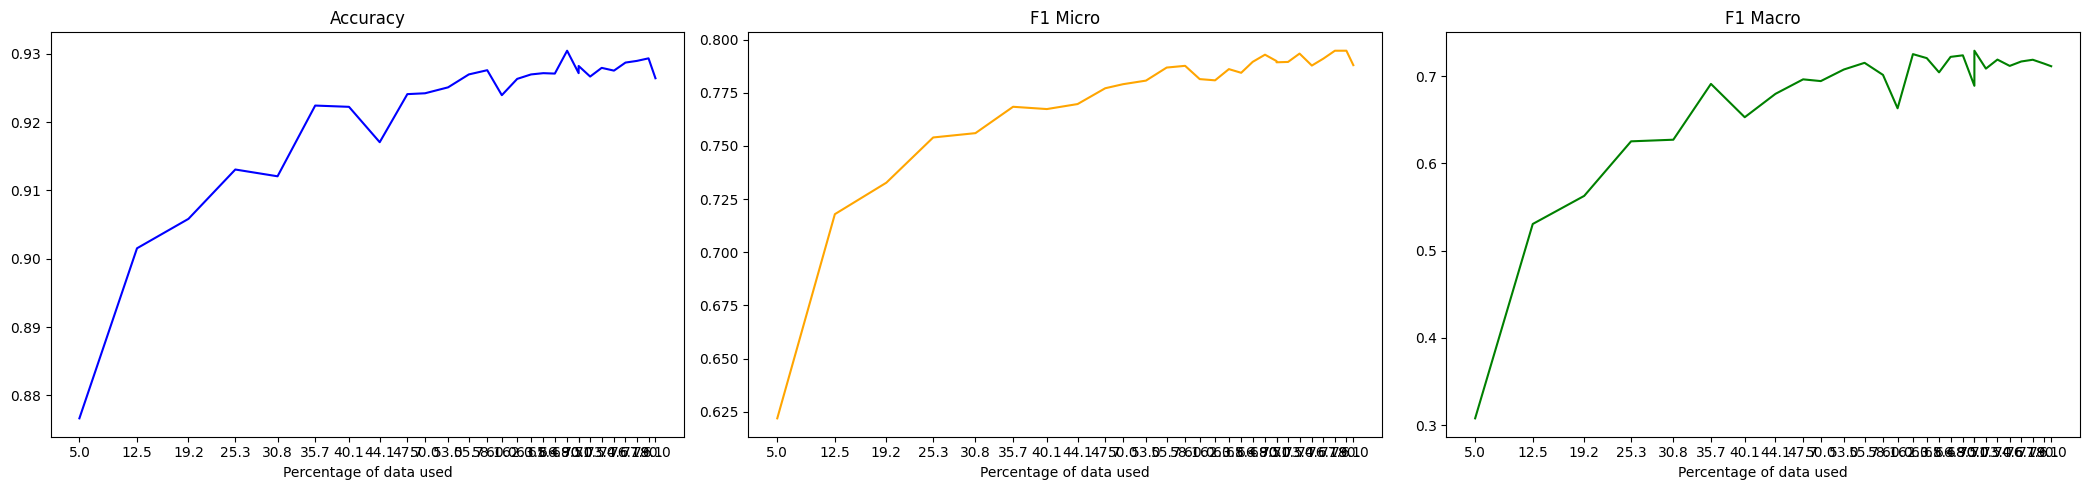

In [22]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.524, Accuracy: 0.8301, F1 Micro: 0.2873, F1 Macro: 0.0657
Epoch 2/10, Train Loss: 0.3962, Accuracy: 0.836, F1 Micro: 0.144, F1 Macro: 0.0516
Epoch 3/10, Train Loss: 0.3689, Accuracy: 0.8477, F1 Micro: 0.2738, F1 Macro: 0.0968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.342, Accuracy: 0.8656, F1 Micro: 0.4801, F1 Macro: 0.2063
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3117, Accuracy: 0.8768, F1 Micro: 0.5736, F1 Macro: 0.2667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2746, Accuracy: 0.88, F1 Micro: 0.5854, F1 Macro: 0.2747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2515, Accuracy: 0.8841, F1 Micro: 0.5877, F1 Macro: 0.2855
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2305, Accuracy: 0.8869, F1 Micro: 0.6337, F1 Macro: 0.3399
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2015, Accuracy: 0.8891, F1 Micro: 0.6409, F1 Macro: 0.3499
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4609, Accuracy: 0.8378, F1 Micro: 0.1695, F1 Macro: 0.0533
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3637, Accuracy: 0.8734, F1 Micro: 0.5282, F1 Macro: 0.2342
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.307, Accuracy: 0.8811, F1 Micro: 0.5563, F1 Macro: 0.2667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2487, Accuracy: 0.8949, F1 Micro: 0.6519, F1 Macro: 0.3893
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2154, Accuracy: 0.8971, F1 Micro: 0.6565, F1 Macro: 0.4261
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1886, Accuracy: 0.9036, F1 Micro: 0.6846, F1 Macro: 0.5008
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1605, Accuracy: 0.9039, F1 Micro: 0.6999, F1 Macro: 0.4953
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.14, Accuracy: 0.9041, F1 Micro: 0.707, F1 Macro: 0.5041
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4424, Accuracy: 0.8518, F1 Micro: 0.3267, F1 Macro: 0.105
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3362, Accuracy: 0.8903, F1 Micro: 0.6335, F1 Macro: 0.3364
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2676, Accuracy: 0.9009, F1 Micro: 0.6667, F1 Macro: 0.3991
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2271, Accuracy: 0.908, F1 Micro: 0.7266, F1 Macro: 0.5216
Epoch 5/10, Train Loss: 0.1831, Accuracy: 0.9116, F1 Micro: 0.724, F1 Macro: 0.5352
Epoch 6/10, Train Loss: 0.159, Accuracy: 0.911, F1 Micro: 0.7222, F1 Macro: 0.551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1341, Accuracy: 0.9148, F1 Micro: 0.7399, F1 Macro: 0.5708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1116, Accuracy: 0.9134, F1 Micro: 0.7405, F1 Macro: 0.5837
Epoch 9/10, Train Loss: 0.0992, Accuracy: 0.9139, F1 Micro: 0.7402, F1 Macro: 0.5809
Epoch 10/10, Train Loss: 0.0852, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4276, Accuracy: 0.861, F1 Micro: 0.394, F1 Macro: 0.1644
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3183, Accuracy: 0.898, F1 Micro: 0.6538, F1 Macro: 0.398
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2536, Accuracy: 0.9083, F1 Micro: 0.7026, F1 Macro: 0.5107
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2057, Accuracy: 0.9093, F1 Micro: 0.7329, F1 Macro: 0.5482
Epoch 5/10, Train Loss: 0.174, Accuracy: 0.9134, F1 Micro: 0.7235, F1 Macro: 0.5602
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1402, Accuracy: 0.9164, F1 Micro: 0.7497, F1 Macro: 0.5833
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9146, F1 Micro: 0.7489, F1 Macro: 0.588
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1013, Accuracy: 0.9162, F1 Micro: 0.7506, F1 Macro: 0.5946
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.085, Accuracy: 0.9172, F1 Micro: 0.7546, F1 Macro: 0.6329
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4205, Accuracy: 0.8811, F1 Micro: 0.5555, F1 Macro: 0.2651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2992, Accuracy: 0.9025, F1 Micro: 0.7064, F1 Macro: 0.4869
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2436, Accuracy: 0.9111, F1 Micro: 0.7112, F1 Macro: 0.5252
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1961, Accuracy: 0.9181, F1 Micro: 0.7522, F1 Macro: 0.574
Epoch 5/10, Train Loss: 0.1641, Accuracy: 0.9189, F1 Micro: 0.7485, F1 Macro: 0.5949
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9196, F1 Micro: 0.7504, F1 Macro: 0.5995
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9156, F1 Micro: 0.7548, F1 Macro: 0.5925
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9178, F1 Micro: 0.7513, F1 Macro: 0.617
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.9142, F1 Micro: 0.7576, F1 Macro: 0.6267
Epoch 10/10, Train Loss: 0.0722, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4129, Accuracy: 0.8887, F1 Micro: 0.624, F1 Macro: 0.3123
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2844, Accuracy: 0.9073, F1 Micro: 0.7053, F1 Macro: 0.4956
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2391, Accuracy: 0.9143, F1 Micro: 0.7443, F1 Macro: 0.5662
Epoch 4/10, Train Loss: 0.1923, Accuracy: 0.9141, F1 Micro: 0.7431, F1 Macro: 0.5451
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1525, Accuracy: 0.9188, F1 Micro: 0.7593, F1 Macro: 0.6082
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.9231, F1 Micro: 0.7646, F1 Macro: 0.6221
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9205, F1 Micro: 0.7551, F1 Macro: 0.5992
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9159, F1 Micro: 0.7662, F1 Macro: 0.6413
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.918, F1 Micro: 0.7644, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4049, Accuracy: 0.8906, F1 Micro: 0.6536, F1 Macro: 0.3432
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2841, Accuracy: 0.9104, F1 Micro: 0.7142, F1 Macro: 0.5247
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2306, Accuracy: 0.915, F1 Micro: 0.7498, F1 Macro: 0.5751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9179, F1 Micro: 0.7561, F1 Macro: 0.5992
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9175, F1 Micro: 0.7625, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1203, Accuracy: 0.9211, F1 Micro: 0.7695, F1 Macro: 0.6252
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9224, F1 Micro: 0.7716, F1 Macro: 0.6567
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.922, F1 Micro: 0.7712, F1 Macro: 0.6749
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9213, F1 Micro: 0.7703, F1 Macro: 0.6508
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3973, Accuracy: 0.8932, F1 Micro: 0.6649, F1 Macro: 0.3833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.278, Accuracy: 0.9102, F1 Micro: 0.7386, F1 Macro: 0.5488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2193, Accuracy: 0.9167, F1 Micro: 0.7548, F1 Macro: 0.5882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9229, F1 Micro: 0.7653, F1 Macro: 0.6079
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9208, F1 Micro: 0.7488, F1 Macro: 0.6079
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9211, F1 Micro: 0.7599, F1 Macro: 0.6241
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.9222, F1 Micro: 0.7623, F1 Macro: 0.6297
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9226, F1 Micro: 0.7701, F1 Macro: 0.6757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.9223, F1 Micro: 0.7755, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3865, Accuracy: 0.8967, F1 Micro: 0.6546, F1 Macro: 0.3835
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2787, Accuracy: 0.9123, F1 Micro: 0.7121, F1 Macro: 0.5209
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2235, Accuracy: 0.9206, F1 Micro: 0.7592, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9173, F1 Micro: 0.7649, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9227, F1 Micro: 0.7672, F1 Macro: 0.6139
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1125, Accuracy: 0.9222, F1 Micro: 0.7727, F1 Macro: 0.6388
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.9205, F1 Micro: 0.7714, F1 Macro: 0.674
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9239, F1 Micro: 0.7753, F1 Macro: 0.6813
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9233, F1 Micro: 0.7664, F1 Macro: 0.6826
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3871, Accuracy: 0.8999, F1 Micro: 0.6656, F1 Macro: 0.4086
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2707, Accuracy: 0.9123, F1 Micro: 0.7465, F1 Macro: 0.5727
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.918, F1 Micro: 0.7398, F1 Macro: 0.559
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9204, F1 Micro: 0.7662, F1 Macro: 0.5993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9164, F1 Micro: 0.7713, F1 Macro: 0.6322
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.9232, F1 Micro: 0.7609, F1 Macro: 0.6433
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.9228, F1 Micro: 0.769, F1 Macro: 0.6679
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9212, F1 Micro: 0.7688, F1 Macro: 0.6518
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.9237, F1 Micro: 0.7652, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0564, Accuracy: 0.9253, F1 Micro: 0.7727, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3817, Accuracy: 0.9015, F1 Micro: 0.6898, F1 Macro: 0.4603
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2659, Accuracy: 0.9144, F1 Micro: 0.7489, F1 Macro: 0.5603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2158, Accuracy: 0.9227, F1 Micro: 0.7649, F1 Macro: 0.6103
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9224, F1 Micro: 0.7673, F1 Macro: 0.6186
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.9219, F1 Micro: 0.7629, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.925, F1 Micro: 0.7732, F1 Macro: 0.6759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.9237, F1 Micro: 0.7759, F1 Macro: 0.6963
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.9228, F1 Micro: 0.7733, F1 Macro: 0.6928
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.9184, F1 Micro: 0.7703, F1 Macro: 0.7087
Epoch 10/10, Train Loss: 0.0539, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3837, Accuracy: 0.897, F1 Micro: 0.693, F1 Macro: 0.4483
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.269, Accuracy: 0.9161, F1 Micro: 0.752, F1 Macro: 0.5781
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.214, Accuracy: 0.9231, F1 Micro: 0.7647, F1 Macro: 0.6036
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9251, F1 Micro: 0.7692, F1 Macro: 0.6369
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.927, F1 Micro: 0.7783, F1 Macro: 0.6445
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.9261, F1 Micro: 0.7704, F1 Macro: 0.6454
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.9252, F1 Micro: 0.7847, F1 Macro: 0.6967
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9255, F1 Micro: 0.7738, F1 Macro: 0.6713
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.9249, F1 Micro: 0.7774, F1 Macro: 0.7136
Epoch 10/10, Train Loss: 0.0515, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.902, F1 Micro: 0.6731, F1 Macro: 0.4728
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2666, Accuracy: 0.9146, F1 Micro: 0.735, F1 Macro: 0.5342
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2109, Accuracy: 0.92, F1 Micro: 0.7683, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1734, Accuracy: 0.9248, F1 Micro: 0.7737, F1 Macro: 0.632
Epoch 5/10, Train Loss: 0.1396, Accuracy: 0.9201, F1 Micro: 0.771, F1 Macro: 0.6756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1118, Accuracy: 0.9274, F1 Micro: 0.7757, F1 Macro: 0.6641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.927, F1 Micro: 0.7858, F1 Macro: 0.6943
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9218, F1 Micro: 0.7783, F1 Macro: 0.7034
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.9267, F1 Micro: 0.7821, F1 Macro: 0.707
Higher F1 achieved, saving model
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.9027, F1 Micro: 0.7009, F1 Macro: 0.4459
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2643, Accuracy: 0.9167, F1 Micro: 0.7351, F1 Macro: 0.5583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9233, F1 Micro: 0.7729, F1 Macro: 0.6188
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.9231, F1 Micro: 0.7781, F1 Macro: 0.6442
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9277, F1 Micro: 0.7785, F1 Macro: 0.6772
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.9267, F1 Micro: 0.7794, F1 Macro: 0.6936
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9247, F1 Micro: 0.7792, F1 Macro: 0.6964
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.9264, F1 Micro: 0.7848, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.9254, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3706, Accuracy: 0.9011, F1 Micro: 0.6816, F1 Macro: 0.3997
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2586, Accuracy: 0.9152, F1 Micro: 0.7526, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.9227, F1 Micro: 0.7573, F1 Macro: 0.6123
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9246, F1 Micro: 0.777, F1 Macro: 0.6469
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9222, F1 Micro: 0.7812, F1 Macro: 0.6888
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9292, F1 Micro: 0.7859, F1 Macro: 0.6824
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9264, F1 Micro: 0.7717, F1 Macro: 0.6831
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9297, F1 Micro: 0.7907, F1 Macro: 0.7057
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9263, F1 Micro: 0.7852, F1 Macro: 0.7238
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3725, Accuracy: 0.9036, F1 Micro: 0.712, F1 Macro: 0.5079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.9137, F1 Micro: 0.7159, F1 Macro: 0.5369
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.922, F1 Micro: 0.7747, F1 Macro: 0.627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9271, F1 Micro: 0.779, F1 Macro: 0.6711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1333, Accuracy: 0.9227, F1 Micro: 0.7807, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9283, F1 Micro: 0.7827, F1 Macro: 0.6849
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9253, F1 Micro: 0.784, F1 Macro: 0.7032
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.926, F1 Micro: 0.7789, F1 Macro: 0.7147
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9251, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3648, Accuracy: 0.9034, F1 Micro: 0.6878, F1 Macro: 0.4261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2511, Accuracy: 0.9181, F1 Micro: 0.7568, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.9253, F1 Micro: 0.7738, F1 Macro: 0.6219
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9266, F1 Micro: 0.772, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.9273, F1 Micro: 0.7856, F1 Macro: 0.6912
Epoch 6/10, Train Loss: 0.1077, Accuracy: 0.9266, F1 Micro: 0.7802, F1 Macro: 0.6906
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9286, F1 Micro: 0.7867, F1 Macro: 0.714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9291, F1 Micro: 0.7892, F1 Macro: 0.7248
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.9272, F1 Micro: 0.7849, F1 Macro: 0.7176
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3639, Accuracy: 0.9044, F1 Micro: 0.6887, F1 Macro: 0.4986
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.9158, F1 Micro: 0.7533, F1 Macro: 0.5677
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.9252, F1 Micro: 0.7727, F1 Macro: 0.6267
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.927, F1 Micro: 0.7846, F1 Macro: 0.6334
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9234, F1 Micro: 0.7853, F1 Macro: 0.6888
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9264, F1 Micro: 0.7869, F1 Macro: 0.7013
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0865, Accuracy: 0.9298, F1 Micro: 0.7932, F1 Macro: 0.7145
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9289, F1 Micro: 0.7872, F1 Macro: 0.7226
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.9272, F1 Micro: 0.7867, F1 Macro: 0.7266
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3567, Accuracy: 0.9031, F1 Micro: 0.7043, F1 Macro: 0.455
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2449, Accuracy: 0.9182, F1 Micro: 0.754, F1 Macro: 0.5767
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9234, F1 Micro: 0.7683, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.9271, F1 Micro: 0.7853, F1 Macro: 0.68
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.9271, F1 Micro: 0.787, F1 Macro: 0.68
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9239, F1 Micro: 0.7807, F1 Macro: 0.7056
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9293, F1 Micro: 0.7866, F1 Macro: 0.6965
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.9288, F1 Micro: 0.7844, F1 Macro: 0.7109
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9276, F1 Micro: 0.7916, F1 Macro: 0.7217
Epoch 10/10, Train Loss: 0.0502, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3503, Accuracy: 0.9059, F1 Micro: 0.6913, F1 Macro: 0.4833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2411, Accuracy: 0.9213, F1 Micro: 0.747, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1883, Accuracy: 0.9216, F1 Micro: 0.7788, F1 Macro: 0.6289
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9263, F1 Micro: 0.7804, F1 Macro: 0.6821
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9275, F1 Micro: 0.7835, F1 Macro: 0.6846
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9277, F1 Micro: 0.7892, F1 Macro: 0.7092
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9279, F1 Micro: 0.7892, F1 Macro: 0.7154
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9282, F1 Micro: 0.7856, F1 Macro: 0.7126
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9299, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3527, Accuracy: 0.9011, F1 Micro: 0.6675, F1 Macro: 0.4323
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2378, Accuracy: 0.9198, F1 Micro: 0.7561, F1 Macro: 0.5952
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1926, Accuracy: 0.9232, F1 Micro: 0.7766, F1 Macro: 0.6335
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9275, F1 Micro: 0.7891, F1 Macro: 0.6631
Epoch 5/10, Train Loss: 0.1235, Accuracy: 0.9275, F1 Micro: 0.7881, F1 Macro: 0.7024
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.9222, F1 Micro: 0.7826, F1 Macro: 0.6868
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9278, F1 Micro: 0.7887, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9295, F1 Micro: 0.7952, F1 Macro: 0.7325
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9255, F1 Micro: 0.7928, F1 Macro: 0.7299
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0473, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3494, Accuracy: 0.8995, F1 Micro: 0.6403, F1 Macro: 0.4132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2414, Accuracy: 0.9199, F1 Micro: 0.7514, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.925, F1 Micro: 0.7796, F1 Macro: 0.6322
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9268, F1 Micro: 0.7837, F1 Macro: 0.6494
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9272, F1 Micro: 0.788, F1 Macro: 0.693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9263, F1 Micro: 0.7925, F1 Macro: 0.716
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9256, F1 Micro: 0.7859, F1 Macro: 0.7102
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9302, F1 Micro: 0.7946, F1 Macro: 0.7251
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9293, F1 Micro: 0.7933, F1 Macro: 0.7326
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3425, Accuracy: 0.906, F1 Micro: 0.6904, F1 Macro: 0.4826
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.235, Accuracy: 0.919, F1 Micro: 0.7537, F1 Macro: 0.5719
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.9185, F1 Micro: 0.7724, F1 Macro: 0.6338
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.9266, F1 Micro: 0.7778, F1 Macro: 0.6662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9281, F1 Micro: 0.7903, F1 Macro: 0.6833
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.9265, F1 Micro: 0.7875, F1 Macro: 0.6878
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9285, F1 Micro: 0.7873, F1 Macro: 0.6932
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9271, F1 Micro: 0.7812, F1 Macro: 0.7062
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9277, F1 Micro: 0.7913, F1 Macro: 0.7294
Epoch 10/10, Train Loss: 0.0459, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.343, Accuracy: 0.9052, F1 Micro: 0.7173, F1 Macro: 0.4978
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2262, Accuracy: 0.922, F1 Micro: 0.7593, F1 Macro: 0.6056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9236, F1 Micro: 0.7753, F1 Macro: 0.6315
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9274, F1 Micro: 0.7942, F1 Macro: 0.689
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.9266, F1 Micro: 0.7907, F1 Macro: 0.6996
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9255, F1 Micro: 0.7822, F1 Macro: 0.7044
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9323, F1 Micro: 0.7943, F1 Macro: 0.7313
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9293, F1 Micro: 0.7884, F1 Macro: 0.7159
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9314, F1 Micro: 0.7957, F1 Macro: 0.7306
Epoch 10/10, Train Loss: 0.0442, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3336, Accuracy: 0.9047, F1 Micro: 0.6757, F1 Macro: 0.4226
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2224, Accuracy: 0.9228, F1 Micro: 0.7591, F1 Macro: 0.5871
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.9198, F1 Micro: 0.7769, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9235, F1 Micro: 0.7833, F1 Macro: 0.6627
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1133, Accuracy: 0.9298, F1 Micro: 0.7856, F1 Macro: 0.6831
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.9292, F1 Micro: 0.7882, F1 Macro: 0.7055
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9266, F1 Micro: 0.7883, F1 Macro: 0.72
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9282, F1 Micro: 0.7874, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9283, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3316, Accuracy: 0.9097, F1 Micro: 0.7179, F1 Macro: 0.5088
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2244, Accuracy: 0.9152, F1 Micro: 0.7623, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.175, Accuracy: 0.9246, F1 Micro: 0.7672, F1 Macro: 0.6116
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1476, Accuracy: 0.9256, F1 Micro: 0.7858, F1 Macro: 0.6564
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9292, F1 Micro: 0.793, F1 Macro: 0.6692
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.9278, F1 Micro: 0.7871, F1 Macro: 0.6834
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9286, F1 Micro: 0.7891, F1 Macro: 0.7026
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9282, F1 Micro: 0.7922, F1 Macro: 0.7249
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9305, F1 Micro: 0.7914, F1 Macro: 0.7218
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.9284, F1 Micro: 0.7908, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3255, Accuracy: 0.9046, F1 Micro: 0.681, F1 Macro: 0.4037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2162, Accuracy: 0.9194, F1 Micro: 0.7583, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9224, F1 Micro: 0.7803, F1 Macro: 0.6326
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1372, Accuracy: 0.9288, F1 Micro: 0.7813, F1 Macro: 0.6814
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9301, F1 Micro: 0.789, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9291, F1 Micro: 0.7945, F1 Macro: 0.7094
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9239, F1 Micro: 0.7836, F1 Macro: 0.7034
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.9291, F1 Micro: 0.7899, F1 Macro: 0.7225
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9289, F1 Micro: 0.7878, F1 Macro: 0.7243
Epoch 10/10, Train Loss: 0.0423, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3238, Accuracy: 0.9077, F1 Micro: 0.7219, F1 Macro: 0.5148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2187, Accuracy: 0.9182, F1 Micro: 0.7591, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1712, Accuracy: 0.9263, F1 Micro: 0.7751, F1 Macro: 0.6322
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.141, Accuracy: 0.9261, F1 Micro: 0.7861, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1069, Accuracy: 0.9278, F1 Micro: 0.7896, F1 Macro: 0.6858
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9269, F1 Micro: 0.7856, F1 Macro: 0.6944
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.927, F1 Micro: 0.7929, F1 Macro: 0.7167
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9288, F1 Micro: 0.7901, F1 Macro: 0.72
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9269, F1 Micro: 0.7885, F1 Macro: 0.7214
Epoch 10/10, Train Loss: 0.0439, Accuracy

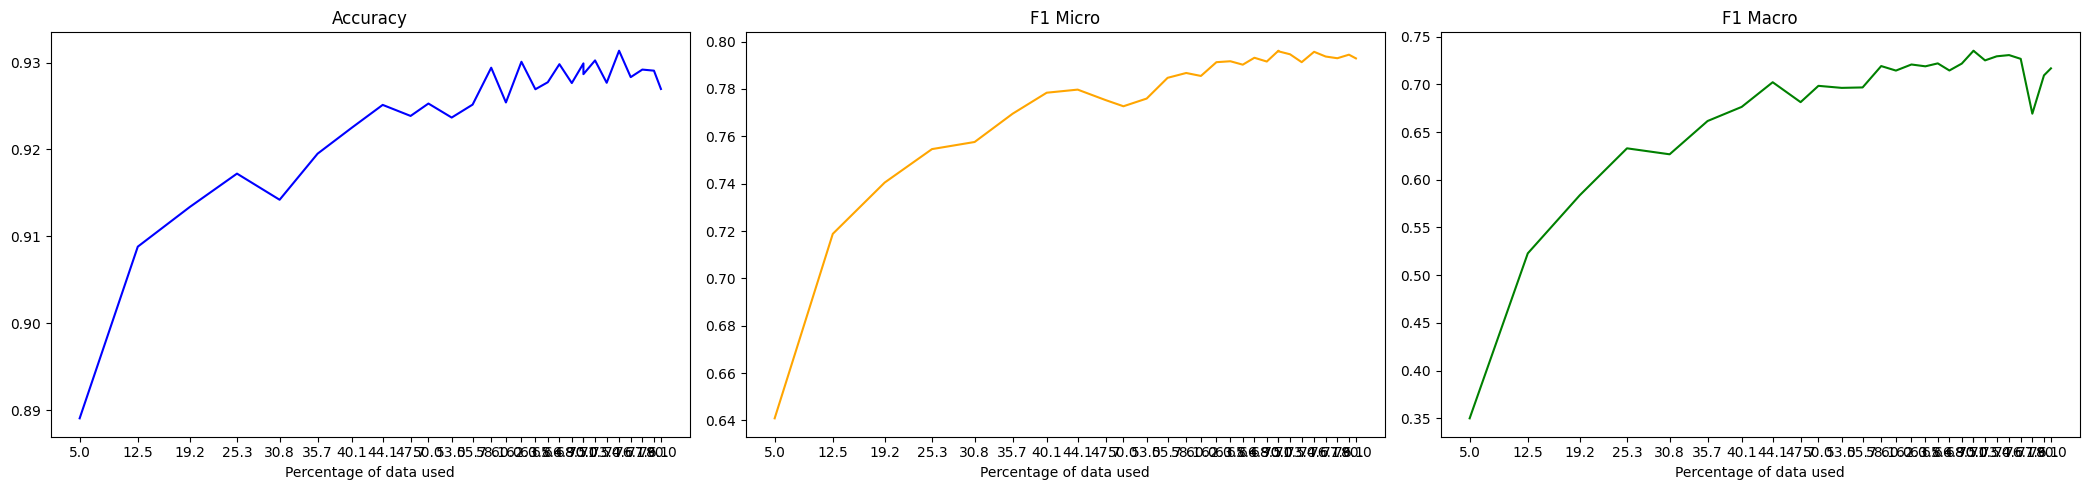

In [23]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5448, Accuracy: 0.8293, F1 Micro: 0.063, F1 Macro: 0.0218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4149, Accuracy: 0.8417, F1 Micro: 0.2125, F1 Macro: 0.0699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.389, Accuracy: 0.8438, F1 Micro: 0.2285, F1 Macro: 0.0804
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3539, Accuracy: 0.8604, F1 Micro: 0.4052, F1 Macro: 0.1597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3143, Accuracy: 0.8723, F1 Micro: 0.5143, F1 Macro: 0.2487
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2817, Accuracy: 0.8774, F1 Micro: 0.5561, F1 Macro: 0.2819
Epoch 7/10, Train Loss: 0.2562, Accuracy: 0.8755, F1 Micro: 0.5114, F1 Macro: 0.2739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2286, Accuracy: 0.884, F1 Micro: 0.5828, F1 Macro: 0.3379
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.204, Accuracy: 0.8891, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4542, Accuracy: 0.8321, F1 Micro: 0.0707, F1 Macro: 0.0276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3458, Accuracy: 0.8635, F1 Micro: 0.4159, F1 Macro: 0.1706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2917, Accuracy: 0.8801, F1 Micro: 0.5707, F1 Macro: 0.2981
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2406, Accuracy: 0.8927, F1 Micro: 0.647, F1 Macro: 0.3837
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2062, Accuracy: 0.8968, F1 Micro: 0.6757, F1 Macro: 0.4402
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1786, Accuracy: 0.9011, F1 Micro: 0.6957, F1 Macro: 0.496
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1539, Accuracy: 0.9006, F1 Micro: 0.6966, F1 Macro: 0.4661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1252, Accuracy: 0.9024, F1 Micro: 0.7026, F1 Macro: 0.5068
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4341, Accuracy: 0.8527, F1 Micro: 0.3125, F1 Macro: 0.1035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3238, Accuracy: 0.8844, F1 Micro: 0.5867, F1 Macro: 0.3011
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2546, Accuracy: 0.8991, F1 Micro: 0.6781, F1 Macro: 0.4348
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2162, Accuracy: 0.8993, F1 Micro: 0.7138, F1 Macro: 0.548
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1752, Accuracy: 0.9048, F1 Micro: 0.7198, F1 Macro: 0.5222
Epoch 6/10, Train Loss: 0.1479, Accuracy: 0.9063, F1 Micro: 0.7145, F1 Macro: 0.5458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1202, Accuracy: 0.9085, F1 Micro: 0.7293, F1 Macro: 0.57
Epoch 8/10, Train Loss: 0.1035, Accuracy: 0.9078, F1 Micro: 0.7268, F1 Macro: 0.5738
Epoch 9/10, Train Loss: 0.0953, Accuracy: 0.9093, F1 Micro: 0.7288, F1 Macro: 0.5804
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4263, Accuracy: 0.8717, F1 Micro: 0.5358, F1 Macro: 0.2426
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3087, Accuracy: 0.8996, F1 Micro: 0.6751, F1 Macro: 0.443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2464, Accuracy: 0.9045, F1 Micro: 0.6764, F1 Macro: 0.498
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2029, Accuracy: 0.907, F1 Micro: 0.7341, F1 Macro: 0.5499
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9098, F1 Micro: 0.7423, F1 Macro: 0.559
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.9115, F1 Micro: 0.7477, F1 Macro: 0.5842
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.9143, F1 Micro: 0.7367, F1 Macro: 0.5725
Epoch 8/10, Train Loss: 0.0929, Accuracy: 0.9143, F1 Micro: 0.7439, F1 Macro: 0.5962
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9149, F1 Micro: 0.7482, F1 Macro: 0.6062
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4168, Accuracy: 0.8778, F1 Micro: 0.5516, F1 Macro: 0.274
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2947, Accuracy: 0.8999, F1 Micro: 0.6899, F1 Macro: 0.4484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2429, Accuracy: 0.911, F1 Micro: 0.7266, F1 Macro: 0.5406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1995, Accuracy: 0.9157, F1 Micro: 0.7479, F1 Macro: 0.5878
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1588, Accuracy: 0.9147, F1 Micro: 0.756, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9173, F1 Micro: 0.7606, F1 Macro: 0.6054
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9119, F1 Micro: 0.7535, F1 Macro: 0.6101
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9183, F1 Micro: 0.7511, F1 Macro: 0.6179
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9183, F1 Micro: 0.7477, F1 Macro: 0.624
Epoch 10/10, Train Loss: 0.0679, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4021, Accuracy: 0.8814, F1 Micro: 0.5638, F1 Macro: 0.2792
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2862, Accuracy: 0.9045, F1 Micro: 0.6713, F1 Macro: 0.4541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.231, Accuracy: 0.9096, F1 Micro: 0.694, F1 Macro: 0.4971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9128, F1 Micro: 0.7546, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1532, Accuracy: 0.9201, F1 Micro: 0.7573, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.919, F1 Micro: 0.7591, F1 Macro: 0.6191
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9172, F1 Micro: 0.7614, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9202, F1 Micro: 0.7668, F1 Macro: 0.6461
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9184, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3966, Accuracy: 0.8898, F1 Micro: 0.6529, F1 Macro: 0.3847
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2782, Accuracy: 0.9095, F1 Micro: 0.7245, F1 Macro: 0.5396
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2299, Accuracy: 0.915, F1 Micro: 0.7532, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9209, F1 Micro: 0.7542, F1 Macro: 0.6017
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9207, F1 Micro: 0.7536, F1 Macro: 0.5945
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9222, F1 Micro: 0.7583, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9224, F1 Micro: 0.7691, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.083, Accuracy: 0.9188, F1 Micro: 0.7593, F1 Macro: 0.6692
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9205, F1 Micro: 0.7613, F1 Macro: 0.6561
Epoch 10/10, Train Loss: 0.0598, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8922, F1 Micro: 0.6569, F1 Macro: 0.4216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2784, Accuracy: 0.9059, F1 Micro: 0.6767, F1 Macro: 0.4699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2211, Accuracy: 0.9185, F1 Micro: 0.7575, F1 Macro: 0.6034
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9183, F1 Micro: 0.7565, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9183, F1 Micro: 0.7616, F1 Macro: 0.6197
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.9213, F1 Micro: 0.7679, F1 Macro: 0.6426
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.919, F1 Micro: 0.7656, F1 Macro: 0.6567
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0771, Accuracy: 0.9216, F1 Micro: 0.768, F1 Macro: 0.6396
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9231, F1 Micro: 0.771, F1 Macro: 0.6685
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3851, Accuracy: 0.8947, F1 Micro: 0.6763, F1 Macro: 0.424
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2733, Accuracy: 0.9129, F1 Micro: 0.7249, F1 Macro: 0.5304
Epoch 3/10, Train Loss: 0.2191, Accuracy: 0.9143, F1 Micro: 0.7098, F1 Macro: 0.5475
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.923, F1 Micro: 0.7639, F1 Macro: 0.6154
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.924, F1 Micro: 0.7759, F1 Macro: 0.6344
Epoch 6/10, Train Loss: 0.116, Accuracy: 0.9218, F1 Micro: 0.7751, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.9211, F1 Micro: 0.7626, F1 Macro: 0.6432
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9227, F1 Micro: 0.7673, F1 Macro: 0.6708
Epoch 9/10, Train Loss: 0.0671, Accuracy: 0.9237, F1 Micro: 0.771, F1 Macro: 0.678
Epoch 10/10, Train Loss: 0.0558, Accuracy: 0.922, F1 Micro: 0.7741, F1 Macro: 0.7042

 Iteration 6285: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3875, Accuracy: 0.8925, F1 Micro: 0.6907, F1 Macro: 0.4649
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2682, Accuracy: 0.9128, F1 Micro: 0.7119, F1 Macro: 0.5032
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2186, Accuracy: 0.9197, F1 Micro: 0.7573, F1 Macro: 0.5961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9211, F1 Micro: 0.7684, F1 Macro: 0.628
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1333, Accuracy: 0.9248, F1 Micro: 0.7771, F1 Macro: 0.6438
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9212, F1 Micro: 0.7722, F1 Macro: 0.6511
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9252, F1 Micro: 0.7738, F1 Macro: 0.6888
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9206, F1 Micro: 0.7759, F1 Macro: 0.687
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.9238, F1 Micro: 0.7826, F1 Macro: 0.6873
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.379, Accuracy: 0.9009, F1 Micro: 0.6939, F1 Macro: 0.4634
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.9139, F1 Micro: 0.7208, F1 Macro: 0.555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2132, Accuracy: 0.9196, F1 Micro: 0.7632, F1 Macro: 0.6104
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9227, F1 Micro: 0.7717, F1 Macro: 0.6267
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9235, F1 Micro: 0.7694, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9219, F1 Micro: 0.7738, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0913, Accuracy: 0.9244, F1 Micro: 0.7794, F1 Macro: 0.6741
Epoch 8/10, Train Loss: 0.0766, Accuracy: 0.9248, F1 Micro: 0.7753, F1 Macro: 0.6926
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0648, Accuracy: 0.9222, F1 Micro: 0.7812, F1 Macro: 0.7119
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3765, Accuracy: 0.8936, F1 Micro: 0.6449, F1 Macro: 0.3621
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.9148, F1 Micro: 0.7216, F1 Macro: 0.5567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2127, Accuracy: 0.9215, F1 Micro: 0.7582, F1 Macro: 0.6074
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9231, F1 Micro: 0.7712, F1 Macro: 0.6344
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9238, F1 Micro: 0.775, F1 Macro: 0.6716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9257, F1 Micro: 0.7792, F1 Macro: 0.6613
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.9233, F1 Micro: 0.7765, F1 Macro: 0.676
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9244, F1 Micro: 0.7721, F1 Macro: 0.6865
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.9233, F1 Micro: 0.7751, F1 Macro: 0.6961
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3671, Accuracy: 0.9025, F1 Micro: 0.7045, F1 Macro: 0.4832
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.9126, F1 Micro: 0.7036, F1 Macro: 0.5282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.9222, F1 Micro: 0.7681, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1613, Accuracy: 0.9231, F1 Micro: 0.7745, F1 Macro: 0.6182
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9238, F1 Micro: 0.7771, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.9263, F1 Micro: 0.7809, F1 Macro: 0.6604
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9256, F1 Micro: 0.7803, F1 Macro: 0.6952
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9267, F1 Micro: 0.7796, F1 Macro: 0.6968
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.9243, F1 Micro: 0.7843, F1 Macro: 0.7098
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3658, Accuracy: 0.8943, F1 Micro: 0.6034, F1 Macro: 0.3796
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.917, F1 Micro: 0.7482, F1 Macro: 0.5721
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9194, F1 Micro: 0.7294, F1 Macro: 0.588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1639, Accuracy: 0.9244, F1 Micro: 0.7726, F1 Macro: 0.6323
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9198, F1 Micro: 0.7743, F1 Macro: 0.6862
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.9258, F1 Micro: 0.7753, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.925, F1 Micro: 0.7838, F1 Macro: 0.6874
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9265, F1 Micro: 0.7832, F1 Macro: 0.6988
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9229, F1 Micro: 0.7789, F1 Macro: 0.7049
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3681, Accuracy: 0.9018, F1 Micro: 0.6695, F1 Macro: 0.4361
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.9187, F1 Micro: 0.75, F1 Macro: 0.5889
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.9219, F1 Micro: 0.7688, F1 Macro: 0.6149
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9191, F1 Micro: 0.7661, F1 Macro: 0.6703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.9267, F1 Micro: 0.7749, F1 Macro: 0.6622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9256, F1 Micro: 0.7778, F1 Macro: 0.6646
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.923, F1 Micro: 0.7813, F1 Macro: 0.7024
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9277, F1 Micro: 0.7773, F1 Macro: 0.6943
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.927, F1 Micro: 0.7894, F1 Macro: 0.7208
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3614, Accuracy: 0.9062, F1 Micro: 0.7054, F1 Macro: 0.5026
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2492, Accuracy: 0.918, F1 Micro: 0.7577, F1 Macro: 0.5745
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1997, Accuracy: 0.9242, F1 Micro: 0.775, F1 Macro: 0.6296
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9235, F1 Micro: 0.771, F1 Macro: 0.6466
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.9258, F1 Micro: 0.785, F1 Macro: 0.6647
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9259, F1 Micro: 0.7748, F1 Macro: 0.6969
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9261, F1 Micro: 0.7844, F1 Macro: 0.7113
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.9258, F1 Micro: 0.7764, F1 Macro: 0.6984
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.9237, F1 Micro: 0.7801, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0483, Accuracy: 0.9267, F1 Micro: 0.7866, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3611, Accuracy: 0.9043, F1 Micro: 0.7013, F1 Macro: 0.4601
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9169, F1 Micro: 0.7541, F1 Macro: 0.5862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.9235, F1 Micro: 0.7698, F1 Macro: 0.6286
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9263, F1 Micro: 0.784, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9269, F1 Micro: 0.7853, F1 Macro: 0.687
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.9254, F1 Micro: 0.7706, F1 Macro: 0.6964
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9235, F1 Micro: 0.7732, F1 Macro: 0.6962
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9218, F1 Micro: 0.7818, F1 Macro: 0.7054
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9283, F1 Micro: 0.7889, F1 Macro: 0.7155
Epoch 10/10, Train Loss: 0.05, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.357, Accuracy: 0.9049, F1 Micro: 0.7018, F1 Macro: 0.4837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2445, Accuracy: 0.9206, F1 Micro: 0.7504, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9234, F1 Micro: 0.776, F1 Macro: 0.628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9259, F1 Micro: 0.7823, F1 Macro: 0.6593
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9275, F1 Micro: 0.7819, F1 Macro: 0.6607
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9246, F1 Micro: 0.7821, F1 Macro: 0.7045
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9268, F1 Micro: 0.7794, F1 Macro: 0.7033
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9244, F1 Micro: 0.7829, F1 Macro: 0.7098
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.9173, F1 Micro: 0.7759, F1 Macro: 0.7028
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0443, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3545, Accuracy: 0.9046, F1 Micro: 0.7029, F1 Macro: 0.4957
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2469, Accuracy: 0.921, F1 Micro: 0.7677, F1 Macro: 0.6092
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9248, F1 Micro: 0.7603, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.152, Accuracy: 0.9266, F1 Micro: 0.7784, F1 Macro: 0.6345
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.927, F1 Micro: 0.7832, F1 Macro: 0.6851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9262, F1 Micro: 0.7886, F1 Macro: 0.6956
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9221, F1 Micro: 0.7793, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0685, Accuracy: 0.9311, F1 Micro: 0.7935, F1 Macro: 0.7228
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9253, F1 Micro: 0.7839, F1 Macro: 0.7186
Epoch 10/10, Train Loss: 0.049, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3487, Accuracy: 0.9058, F1 Micro: 0.7195, F1 Macro: 0.5306
Epoch 2/10, Train Loss: 0.2384, Accuracy: 0.9146, F1 Micro: 0.7124, F1 Macro: 0.5359
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9225, F1 Micro: 0.7586, F1 Macro: 0.6256
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1501, Accuracy: 0.9245, F1 Micro: 0.783, F1 Macro: 0.6772
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.927, F1 Micro: 0.7823, F1 Macro: 0.6621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.9269, F1 Micro: 0.7891, F1 Macro: 0.7152
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.9266, F1 Micro: 0.7833, F1 Macro: 0.7104
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9246, F1 Micro: 0.7785, F1 Macro: 0.7118
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9276, F1 Micro: 0.7871, F1 Macro: 0.7249
Epoch 10/10, Train Loss: 0.0446, Accuracy: 0.9266, F1 Micro: 0.7759, F1 Macro: 0.7089

 Iteration 9216: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3454, Accuracy: 0.9041, F1 Micro: 0.7142, F1 Macro: 0.4775
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2403, Accuracy: 0.9181, F1 Micro: 0.7412, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.9265, F1 Micro: 0.7753, F1 Macro: 0.6343
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9241, F1 Micro: 0.7813, F1 Macro: 0.6572
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9271, F1 Micro: 0.7854, F1 Macro: 0.698
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9244, F1 Micro: 0.7825, F1 Macro: 0.6958
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9248, F1 Micro: 0.7848, F1 Macro: 0.7147
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9252, F1 Micro: 0.7884, F1 Macro: 0.7261
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9243, F1 Micro: 0.7722, F1 Macro: 0.6906
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3412, Accuracy: 0.9027, F1 Micro: 0.6839, F1 Macro: 0.4206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2385, Accuracy: 0.9209, F1 Micro: 0.7517, F1 Macro: 0.5909
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1878, Accuracy: 0.9249, F1 Micro: 0.7788, F1 Macro: 0.6304
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.925, F1 Micro: 0.7795, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9271, F1 Micro: 0.7881, F1 Macro: 0.6887
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9265, F1 Micro: 0.7909, F1 Macro: 0.7061
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9278, F1 Micro: 0.7836, F1 Macro: 0.7083
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9241, F1 Micro: 0.7863, F1 Macro: 0.7173
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.927, F1 Micro: 0.7891, F1 Macro: 0.7205
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3409, Accuracy: 0.9058, F1 Micro: 0.6927, F1 Macro: 0.4666
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2282, Accuracy: 0.921, F1 Micro: 0.7565, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.9234, F1 Micro: 0.7774, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9244, F1 Micro: 0.7865, F1 Macro: 0.6708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9287, F1 Micro: 0.7925, F1 Macro: 0.7027
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9269, F1 Micro: 0.7905, F1 Macro: 0.7022
Epoch 7/10, Train Loss: 0.0758, Accuracy: 0.9259, F1 Micro: 0.7891, F1 Macro: 0.7126
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9233, F1 Micro: 0.7841, F1 Macro: 0.7117
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9258, F1 Micro: 0.7831, F1 Macro: 0.7092
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0444, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3427, Accuracy: 0.9015, F1 Micro: 0.6643, F1 Macro: 0.4778
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2278, Accuracy: 0.9198, F1 Micro: 0.7524, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9272, F1 Micro: 0.7777, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9279, F1 Micro: 0.7889, F1 Macro: 0.6694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9318, F1 Micro: 0.798, F1 Macro: 0.7002
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9293, F1 Micro: 0.7868, F1 Macro: 0.7039
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.928, F1 Micro: 0.7927, F1 Macro: 0.7144
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9271, F1 Micro: 0.7891, F1 Macro: 0.715
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9285, F1 Micro: 0.7932, F1 Macro: 0.7226
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.9293, F1 Micro: 0.794, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3333, Accuracy: 0.9075, F1 Micro: 0.7179, F1 Macro: 0.4987
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2246, Accuracy: 0.92, F1 Micro: 0.7598, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.924, F1 Micro: 0.7795, F1 Macro: 0.6488
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.9268, F1 Micro: 0.7728, F1 Macro: 0.662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.9275, F1 Micro: 0.7888, F1 Macro: 0.6898
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9272, F1 Micro: 0.7836, F1 Macro: 0.6759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9272, F1 Micro: 0.7912, F1 Macro: 0.7107
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9255, F1 Micro: 0.785, F1 Macro: 0.7177
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9245, F1 Micro: 0.7863, F1 Macro: 0.7239
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.044, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3283, Accuracy: 0.9073, F1 Micro: 0.7051, F1 Macro: 0.5045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2205, Accuracy: 0.9209, F1 Micro: 0.7597, F1 Macro: 0.6001
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9255, F1 Micro: 0.7743, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.142, Accuracy: 0.9257, F1 Micro: 0.7801, F1 Macro: 0.6775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1105, Accuracy: 0.9233, F1 Micro: 0.7831, F1 Macro: 0.6815
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9259, F1 Micro: 0.7796, F1 Macro: 0.7048
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9283, F1 Micro: 0.793, F1 Macro: 0.7259
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9295, F1 Micro: 0.7911, F1 Macro: 0.7174
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9295, F1 Micro: 0.7868, F1 Macro: 0.707
Epoch 10/10, Train Loss: 0.0438, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3192, Accuracy: 0.9081, F1 Micro: 0.7264, F1 Macro: 0.5119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2151, Accuracy: 0.9201, F1 Micro: 0.7464, F1 Macro: 0.577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1704, Accuracy: 0.9252, F1 Micro: 0.7759, F1 Macro: 0.6455
Epoch 4/10, Train Loss: 0.1367, Accuracy: 0.9221, F1 Micro: 0.7709, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1115, Accuracy: 0.9291, F1 Micro: 0.7824, F1 Macro: 0.6698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9252, F1 Micro: 0.7881, F1 Macro: 0.688
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9288, F1 Micro: 0.7887, F1 Macro: 0.7123
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9286, F1 Micro: 0.7885, F1 Macro: 0.7194
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9268, F1 Micro: 0.7821, F1 Macro: 0.7103
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3236, Accuracy: 0.9036, F1 Micro: 0.6631, F1 Macro: 0.45
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.213, Accuracy: 0.9224, F1 Micro: 0.7662, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1725, Accuracy: 0.9246, F1 Micro: 0.7833, F1 Macro: 0.6437
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.9296, F1 Micro: 0.7929, F1 Macro: 0.6682
Epoch 5/10, Train Loss: 0.1072, Accuracy: 0.9275, F1 Micro: 0.7777, F1 Macro: 0.6609
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.9237, F1 Micro: 0.7833, F1 Macro: 0.6965
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.9284, F1 Micro: 0.7931, F1 Macro: 0.717
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.9252, F1 Micro: 0.7874, F1 Macro: 0.7199
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9266, F1 Micro: 0.7893, F1 Macro: 0.7235
Epoch 10/10, Train Loss: 0.0396, Accuracy: 0.928, F1 Micro: 0.7903, F1 Mac

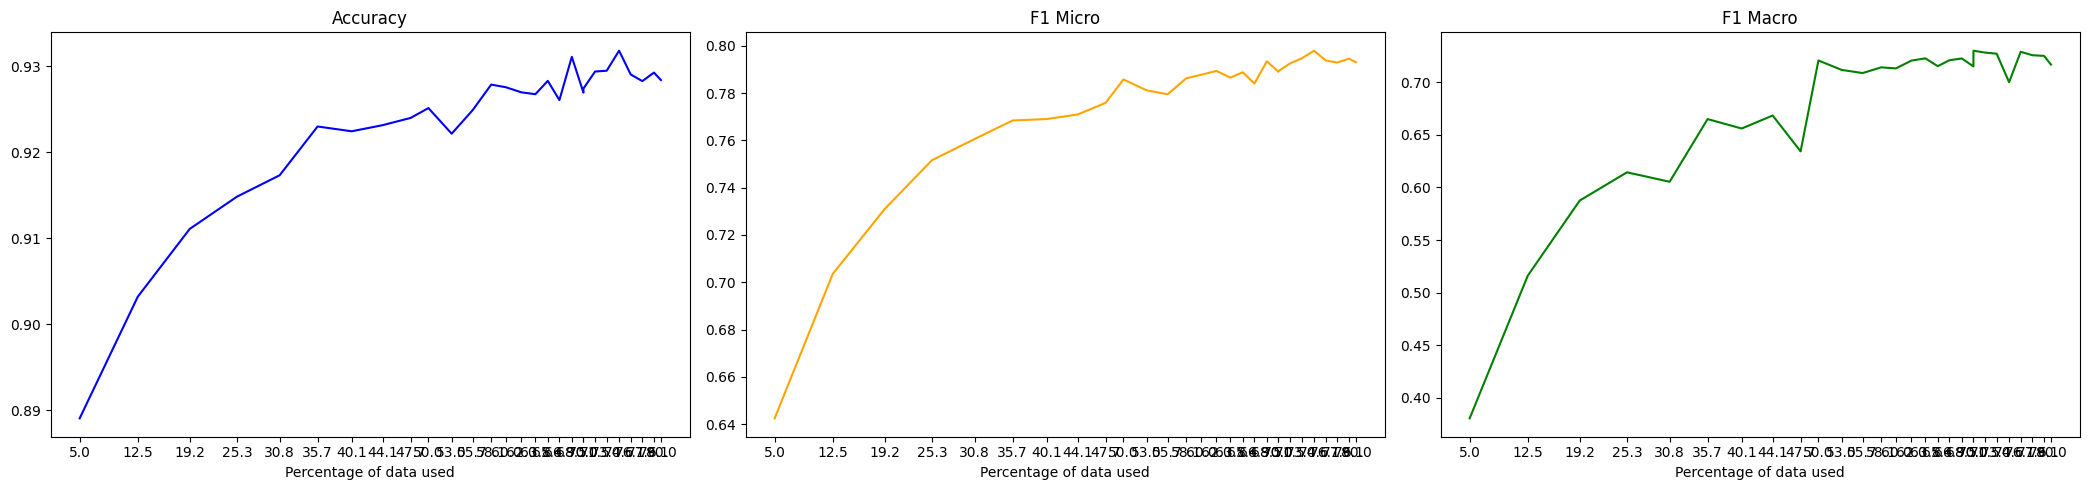

In [24]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5523, Accuracy: 0.8279, F1 Micro: 0.0267, F1 Macro: 0.0113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4113, Accuracy: 0.8342, F1 Micro: 0.1125, F1 Macro: 0.0406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.372, Accuracy: 0.844, F1 Micro: 0.2472, F1 Macro: 0.0837
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3504, Accuracy: 0.8621, F1 Micro: 0.468, F1 Macro: 0.1904
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3382, Accuracy: 0.8729, F1 Micro: 0.5892, F1 Macro: 0.2711
Epoch 6/10, Train Loss: 0.2935, Accuracy: 0.8774, F1 Micro: 0.5687, F1 Macro: 0.2658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2645, Accuracy: 0.8822, F1 Micro: 0.6084, F1 Macro: 0.293
Epoch 8/10, Train Loss: 0.2436, Accuracy: 0.8842, F1 Micro: 0.6042, F1 Macro: 0.3032
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2213, Accuracy: 0.8868, F1 Micro: 0.6313, F1 Macro: 0.3455
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4759, Accuracy: 0.8304, F1 Micro: 0.0497, F1 Macro: 0.0205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3733, Accuracy: 0.863, F1 Micro: 0.4002, F1 Macro: 0.1502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3147, Accuracy: 0.8822, F1 Micro: 0.5904, F1 Macro: 0.2751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2635, Accuracy: 0.8881, F1 Micro: 0.6388, F1 Macro: 0.3242
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2147, Accuracy: 0.8914, F1 Micro: 0.6727, F1 Macro: 0.393
Epoch 6/10, Train Loss: 0.1954, Accuracy: 0.8978, F1 Micro: 0.6547, F1 Macro: 0.4582
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1728, Accuracy: 0.9009, F1 Micro: 0.7036, F1 Macro: 0.5081
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1465, Accuracy: 0.9028, F1 Micro: 0.7103, F1 Macro: 0.4913
Epoch 9/10, Train Loss: 0.1251, Accuracy: 0.9006, F1 Micro: 0.6809, F1 Macro: 0.495
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4375, Accuracy: 0.8466, F1 Micro: 0.2684, F1 Macro: 0.0886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3265, Accuracy: 0.8817, F1 Micro: 0.5695, F1 Macro: 0.2678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2691, Accuracy: 0.8964, F1 Micro: 0.6622, F1 Macro: 0.4133
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.232, Accuracy: 0.9035, F1 Micro: 0.709, F1 Macro: 0.4938
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1951, Accuracy: 0.9043, F1 Micro: 0.7118, F1 Macro: 0.5083
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1656, Accuracy: 0.9083, F1 Micro: 0.7132, F1 Macro: 0.5104
Epoch 7/10, Train Loss: 0.1308, Accuracy: 0.9063, F1 Micro: 0.6947, F1 Macro: 0.5188
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1165, Accuracy: 0.9081, F1 Micro: 0.721, F1 Macro: 0.5502
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0965, Accuracy: 0.9112, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4231, Accuracy: 0.8708, F1 Micro: 0.4998, F1 Macro: 0.2086
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3162, Accuracy: 0.8943, F1 Micro: 0.6262, F1 Macro: 0.3658
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2504, Accuracy: 0.9037, F1 Micro: 0.6769, F1 Macro: 0.4429
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2025, Accuracy: 0.9081, F1 Micro: 0.7359, F1 Macro: 0.5502
Epoch 5/10, Train Loss: 0.1689, Accuracy: 0.9118, F1 Micro: 0.729, F1 Macro: 0.553
Epoch 6/10, Train Loss: 0.1344, Accuracy: 0.9094, F1 Micro: 0.7348, F1 Macro: 0.5657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9123, F1 Micro: 0.7447, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.9157, F1 Micro: 0.7448, F1 Macro: 0.6021
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9151, F1 Micro: 0.7481, F1 Macro: 0.6082
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4214, Accuracy: 0.8804, F1 Micro: 0.5773, F1 Macro: 0.2652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3033, Accuracy: 0.9014, F1 Micro: 0.6889, F1 Macro: 0.4573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2412, Accuracy: 0.9089, F1 Micro: 0.7311, F1 Macro: 0.5474
Epoch 4/10, Train Loss: 0.1995, Accuracy: 0.9133, F1 Micro: 0.7298, F1 Macro: 0.5479
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1586, Accuracy: 0.9152, F1 Micro: 0.734, F1 Macro: 0.5782
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1288, Accuracy: 0.9164, F1 Micro: 0.7468, F1 Macro: 0.5981
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9156, F1 Micro: 0.7601, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9184, F1 Micro: 0.7489, F1 Macro: 0.6337
Epoch 9/10, Train Loss: 0.0717, Accuracy: 0.9189, F1 Micro: 0.7559, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4149, Accuracy: 0.882, F1 Micro: 0.5603, F1 Macro: 0.2598
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2932, Accuracy: 0.9069, F1 Micro: 0.6943, F1 Macro: 0.4773
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2367, Accuracy: 0.9153, F1 Micro: 0.7472, F1 Macro: 0.5644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1946, Accuracy: 0.9192, F1 Micro: 0.7558, F1 Macro: 0.5912
Epoch 5/10, Train Loss: 0.1539, Accuracy: 0.9199, F1 Micro: 0.7465, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.126, Accuracy: 0.9201, F1 Micro: 0.7598, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1024, Accuracy: 0.9182, F1 Micro: 0.7664, F1 Macro: 0.6453
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0883, Accuracy: 0.9228, F1 Micro: 0.7739, F1 Macro: 0.6711
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9214, F1 Micro: 0.7672, F1 Macro: 0.6645
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4057, Accuracy: 0.8849, F1 Micro: 0.5875, F1 Macro: 0.293
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2902, Accuracy: 0.9101, F1 Micro: 0.7263, F1 Macro: 0.5224
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2279, Accuracy: 0.9159, F1 Micro: 0.7303, F1 Macro: 0.5501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1827, Accuracy: 0.9207, F1 Micro: 0.7632, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9213, F1 Micro: 0.7666, F1 Macro: 0.6332
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9218, F1 Micro: 0.7685, F1 Macro: 0.6333
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.9218, F1 Micro: 0.7743, F1 Macro: 0.6797
Epoch 8/10, Train Loss: 0.0767, Accuracy: 0.9207, F1 Micro: 0.7609, F1 Macro: 0.6684
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9208, F1 Micro: 0.77, F1 Macro: 0.6898
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4022, Accuracy: 0.8899, F1 Micro: 0.611, F1 Macro: 0.3098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2768, Accuracy: 0.9126, F1 Micro: 0.7332, F1 Macro: 0.5591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2231, Accuracy: 0.9164, F1 Micro: 0.7519, F1 Macro: 0.5827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9167, F1 Micro: 0.761, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9229, F1 Micro: 0.7685, F1 Macro: 0.6267
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9235, F1 Micro: 0.7698, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.926, F1 Micro: 0.7734, F1 Macro: 0.6664
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.9221, F1 Micro: 0.7742, F1 Macro: 0.6914
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.924, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3922, Accuracy: 0.8931, F1 Micro: 0.6257, F1 Macro: 0.3596
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2749, Accuracy: 0.9107, F1 Micro: 0.7022, F1 Macro: 0.5188
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2193, Accuracy: 0.9194, F1 Micro: 0.7571, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9218, F1 Micro: 0.7575, F1 Macro: 0.6245
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9159, F1 Micro: 0.7602, F1 Macro: 0.6324
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.9245, F1 Micro: 0.7726, F1 Macro: 0.6857
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0961, Accuracy: 0.9238, F1 Micro: 0.7778, F1 Macro: 0.7005
Epoch 8/10, Train Loss: 0.0766, Accuracy: 0.9247, F1 Micro: 0.7739, F1 Macro: 0.6898
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9261, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3879, Accuracy: 0.8976, F1 Micro: 0.6559, F1 Macro: 0.4215
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2766, Accuracy: 0.9129, F1 Micro: 0.724, F1 Macro: 0.5686
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2188, Accuracy: 0.9204, F1 Micro: 0.763, F1 Macro: 0.611
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.9224, F1 Micro: 0.7718, F1 Macro: 0.6386
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9243, F1 Micro: 0.7702, F1 Macro: 0.6401
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9216, F1 Micro: 0.7705, F1 Macro: 0.6648
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9236, F1 Micro: 0.7774, F1 Macro: 0.6904
Epoch 8/10, Train Loss: 0.0752, Accuracy: 0.9227, F1 Micro: 0.7773, F1 Macro: 0.6966
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9253, F1 Micro: 0.7717, F1 Macro: 0.7021
Epoch 10/10, Train Loss: 0.053, Accuracy: 0.9246, F1 Micro: 0.7754, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3825, Accuracy: 0.8996, F1 Micro: 0.6672, F1 Macro: 0.406
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.9134, F1 Micro: 0.7175, F1 Macro: 0.5092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.9165, F1 Micro: 0.7599, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9239, F1 Micro: 0.766, F1 Macro: 0.6432
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.9228, F1 Micro: 0.7746, F1 Macro: 0.662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.9241, F1 Micro: 0.7748, F1 Macro: 0.6906
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.919, F1 Micro: 0.7692, F1 Macro: 0.6879
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9263, F1 Micro: 0.7797, F1 Macro: 0.7007
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9236, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3788, Accuracy: 0.9003, F1 Micro: 0.6853, F1 Macro: 0.409
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2608, Accuracy: 0.9109, F1 Micro: 0.7502, F1 Macro: 0.5703
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2053, Accuracy: 0.9198, F1 Micro: 0.7731, F1 Macro: 0.6117
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9245, F1 Micro: 0.7732, F1 Macro: 0.6711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9268, F1 Micro: 0.7794, F1 Macro: 0.6724
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.927, F1 Micro: 0.7745, F1 Macro: 0.6943
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0865, Accuracy: 0.9238, F1 Micro: 0.7799, F1 Macro: 0.6881
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9276, F1 Micro: 0.7841, F1 Macro: 0.718
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.9293, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3762, Accuracy: 0.9013, F1 Micro: 0.6919, F1 Macro: 0.438
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2624, Accuracy: 0.9181, F1 Micro: 0.7562, F1 Macro: 0.5688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9223, F1 Micro: 0.7591, F1 Macro: 0.6104
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9203, F1 Micro: 0.7706, F1 Macro: 0.6309
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.132, Accuracy: 0.926, F1 Micro: 0.7748, F1 Macro: 0.6791
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9284, F1 Micro: 0.784, F1 Macro: 0.695
Epoch 7/10, Train Loss: 0.0881, Accuracy: 0.9246, F1 Micro: 0.7782, F1 Macro: 0.6961
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9269, F1 Micro: 0.7782, F1 Macro: 0.7084
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.9252, F1 Micro: 0.7724, F1 Macro: 0.7083
Epoch 10/10, Train Loss: 0.0521, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3719, Accuracy: 0.9016, F1 Micro: 0.7099, F1 Macro: 0.4911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2598, Accuracy: 0.9173, F1 Micro: 0.75, F1 Macro: 0.5546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.923, F1 Micro: 0.7599, F1 Macro: 0.615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9234, F1 Micro: 0.7734, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9231, F1 Micro: 0.777, F1 Macro: 0.6892
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.9247, F1 Micro: 0.7815, F1 Macro: 0.6914
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9275, F1 Micro: 0.782, F1 Macro: 0.6997
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9272, F1 Micro: 0.7843, F1 Macro: 0.7092
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9258, F1 Micro: 0.78

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3708, Accuracy: 0.9045, F1 Micro: 0.7101, F1 Macro: 0.5069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2576, Accuracy: 0.9159, F1 Micro: 0.741, F1 Macro: 0.5267
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.9244, F1 Micro: 0.7748, F1 Macro: 0.6269
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9256, F1 Micro: 0.7833, F1 Macro: 0.6584
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.925, F1 Micro: 0.7783, F1 Macro: 0.6909
Epoch 6/10, Train Loss: 0.1052, Accuracy: 0.9181, F1 Micro: 0.7722, F1 Macro: 0.6922
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9285, F1 Micro: 0.7858, F1 Macro: 0.7159
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.928, F1 Micro: 0.7843, F1 Macro: 0.7076
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.9268, F1 Micro: 0.7903, F1 Macro: 0.7275
Epoch 10/10, Train Loss: 0.0489, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3694, Accuracy: 0.8966, F1 Micro: 0.7064, F1 Macro: 0.5208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.916, F1 Micro: 0.7556, F1 Macro: 0.578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9245, F1 Micro: 0.7725, F1 Macro: 0.6235
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9225, F1 Micro: 0.7775, F1 Macro: 0.6899
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9201, F1 Micro: 0.7769, F1 Macro: 0.7042
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9199, F1 Micro: 0.7782, F1 Macro: 0.7064
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0851, Accuracy: 0.9264, F1 Micro: 0.7818, F1 Macro: 0.7019
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9259, F1 Micro: 0.7786, F1 Macro: 0.7066
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9225, F1 Micro: 0.7816, F1 Macro: 0.7143
Epoch 10/10, Train Loss: 0.0491, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3643, Accuracy: 0.903, F1 Micro: 0.6951, F1 Macro: 0.4453
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2504, Accuracy: 0.9198, F1 Micro: 0.7473, F1 Macro: 0.564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9232, F1 Micro: 0.7715, F1 Macro: 0.6588
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.9255, F1 Micro: 0.7697, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9233, F1 Micro: 0.7774, F1 Macro: 0.6958
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9283, F1 Micro: 0.7882, F1 Macro: 0.7065
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0829, Accuracy: 0.9304, F1 Micro: 0.7948, F1 Macro: 0.7097
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.9292, F1 Micro: 0.7839, F1 Macro: 0.7124
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9278, F1 Micro: 0.7884, F1 Macro: 0.7274
Epoch 10/10, Train Loss: 0.0474, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3613, Accuracy: 0.9027, F1 Micro: 0.6976, F1 Macro: 0.4267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.9175, F1 Micro: 0.7331, F1 Macro: 0.5375
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9259, F1 Micro: 0.7772, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9233, F1 Micro: 0.7776, F1 Macro: 0.6777
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.9275, F1 Micro: 0.7818, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9274, F1 Micro: 0.7881, F1 Macro: 0.7151
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9261, F1 Micro: 0.7856, F1 Macro: 0.7238
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9266, F1 Micro: 0.7764, F1 Macro: 0.7076
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9239, F1 Micro: 0.7834, F1 Macro: 0.7231
Epoch 10/10, Train Loss: 0.0503, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3566, Accuracy: 0.9044, F1 Micro: 0.6906, F1 Macro: 0.4399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2401, Accuracy: 0.9187, F1 Micro: 0.7478, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1939, Accuracy: 0.926, F1 Micro: 0.7724, F1 Macro: 0.6243
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.928, F1 Micro: 0.7861, F1 Macro: 0.6626
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9255, F1 Micro: 0.7835, F1 Macro: 0.6991
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9264, F1 Micro: 0.787, F1 Macro: 0.706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9269, F1 Micro: 0.7894, F1 Macro: 0.7195
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9258, F1 Micro: 0.7816, F1 Macro: 0.7116
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9262, F1 Micro: 0.7828, F1 Macro: 0.723
Epoch 10/10, Train Loss: 0.0467, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3575, Accuracy: 0.9038, F1 Micro: 0.6966, F1 Macro: 0.4573
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2427, Accuracy: 0.9157, F1 Micro: 0.729, F1 Macro: 0.5141
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1915, Accuracy: 0.923, F1 Micro: 0.7743, F1 Macro: 0.6248
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1517, Accuracy: 0.929, F1 Micro: 0.7857, F1 Macro: 0.6695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1235, Accuracy: 0.9283, F1 Micro: 0.7885, F1 Macro: 0.7101
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.9266, F1 Micro: 0.7819, F1 Macro: 0.7025
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9272, F1 Micro: 0.7901, F1 Macro: 0.7251
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9276, F1 Micro: 0.7921, F1 Macro: 0.7254
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9254, F1 Micro: 0.7846, F1 Macro: 0.7209
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3561, Accuracy: 0.9081, F1 Micro: 0.7051, F1 Macro: 0.4692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.9179, F1 Micro: 0.7481, F1 Macro: 0.5484
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.9225, F1 Micro: 0.745, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9266, F1 Micro: 0.7855, F1 Macro: 0.6719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9292, F1 Micro: 0.7879, F1 Macro: 0.7007
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9246, F1 Micro: 0.7779, F1 Macro: 0.6983
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9286, F1 Micro: 0.7891, F1 Macro: 0.724
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9271, F1 Micro: 0.7919, F1 Macro: 0.7266
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9279, F1 Micro: 0.7941, F1 Macro: 0.7275
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3461, Accuracy: 0.9069, F1 Micro: 0.717, F1 Macro: 0.5065
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2407, Accuracy: 0.92, F1 Micro: 0.7584, F1 Macro: 0.5848
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.923, F1 Micro: 0.7787, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9278, F1 Micro: 0.7871, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1167, Accuracy: 0.9289, F1 Micro: 0.7896, F1 Macro: 0.6967
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9284, F1 Micro: 0.7855, F1 Macro: 0.6986
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9249, F1 Micro: 0.7841, F1 Macro: 0.7065
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9263, F1 Micro: 0.7894, F1 Macro: 0.7256
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9293, F1 Micro: 0.7928, F1 Macro: 0.7257
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3458, Accuracy: 0.9064, F1 Micro: 0.7008, F1 Macro: 0.4604
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2322, Accuracy: 0.9209, F1 Micro: 0.7664, F1 Macro: 0.596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.923, F1 Micro: 0.7804, F1 Macro: 0.6308
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.924, F1 Micro: 0.7827, F1 Macro: 0.6861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9278, F1 Micro: 0.786, F1 Macro: 0.6891
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9275, F1 Micro: 0.7846, F1 Macro: 0.7001
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9266, F1 Micro: 0.779, F1 Macro: 0.7032
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9247, F1 Micro: 0.7848, F1 Macro: 0.7163
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9239, F1 Micro: 0.7832, F1 Macro: 0.717
Epoch 10/10, Train Loss: 0.0471, Accuracy: 0.9228, F1 Micro: 0.7842, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3443, Accuracy: 0.9077, F1 Micro: 0.7028, F1 Macro: 0.4701
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2314, Accuracy: 0.919, F1 Micro: 0.7638, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1826, Accuracy: 0.9262, F1 Micro: 0.7706, F1 Macro: 0.6256
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9245, F1 Micro: 0.7833, F1 Macro: 0.6585
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1145, Accuracy: 0.9255, F1 Micro: 0.7834, F1 Macro: 0.6888
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9286, F1 Micro: 0.7897, F1 Macro: 0.7101
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9264, F1 Micro: 0.7831, F1 Macro: 0.7028
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9217, F1 Micro: 0.7816, F1 Macro: 0.7109
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9281, F1 Micro: 0.7879, F1 Macro: 0.7142
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3404, Accuracy: 0.9055, F1 Micro: 0.6777, F1 Macro: 0.4441
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2249, Accuracy: 0.92, F1 Micro: 0.7622, F1 Macro: 0.5701
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1779, Accuracy: 0.9233, F1 Micro: 0.7752, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9287, F1 Micro: 0.7825, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.9265, F1 Micro: 0.7846, F1 Macro: 0.673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.927, F1 Micro: 0.7863, F1 Macro: 0.7049
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9278, F1 Micro: 0.7892, F1 Macro: 0.7119
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9275, F1 Micro: 0.7882, F1 Macro: 0.722
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9271, F1 Micro: 0.7819, F1 Macro: 0.7201
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3314, Accuracy: 0.9023, F1 Micro: 0.7255, F1 Macro: 0.5372
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2225, Accuracy: 0.9201, F1 Micro: 0.762, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1746, Accuracy: 0.9264, F1 Micro: 0.7835, F1 Macro: 0.6459
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9258, F1 Micro: 0.7711, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.9254, F1 Micro: 0.7682, F1 Macro: 0.6757
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.9259, F1 Micro: 0.7823, F1 Macro: 0.7079
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9279, F1 Micro: 0.7866, F1 Macro: 0.7125
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9273, F1 Micro: 0.7834, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9259, F1 Micro: 0.7898, F1 Macro: 0.7249
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.9266, F1 Micro: 0.7872, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3248, Accuracy: 0.9049, F1 Micro: 0.708, F1 Macro: 0.4659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2176, Accuracy: 0.9162, F1 Micro: 0.7632, F1 Macro: 0.5908
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1728, Accuracy: 0.9274, F1 Micro: 0.7743, F1 Macro: 0.6354
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9258, F1 Micro: 0.7641, F1 Macro: 0.6666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1084, Accuracy: 0.9283, F1 Micro: 0.7934, F1 Macro: 0.7045
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.9289, F1 Micro: 0.7882, F1 Macro: 0.7117
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9279, F1 Micro: 0.7882, F1 Macro: 0.7153
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9289, F1 Micro: 0.7898, F1 Macro: 0.7117
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9275, F1 Micro: 0.786, F1 Macro: 0.7213
Epoch 10/10, Train Loss: 0.0375, Accuracy: 0.9265, F1 Micro: 0.7879, F1 Macro: 0.7263

 Iteration 10418: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3237, Accuracy: 0.9061, F1 Micro: 0.7221, F1 Macro: 0.523
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2161, Accuracy: 0.9211, F1 Micro: 0.7493, F1 Macro: 0.5731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1696, Accuracy: 0.9257, F1 Micro: 0.7785, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1325, Accuracy: 0.9255, F1 Micro: 0.7821, F1 Macro: 0.6585
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1062, Accuracy: 0.9264, F1 Micro: 0.7855, F1 Macro: 0.6938
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9279, F1 Micro: 0.7829, F1 Macro: 0.6856
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9282, F1 Micro: 0.7792, F1 Macro: 0.7055
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9278, F1 Micro: 0.7903, F1 Macro: 0.7252
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9293, F1 Micro: 0.7904, F1 Macro: 0.7254
Epoch 

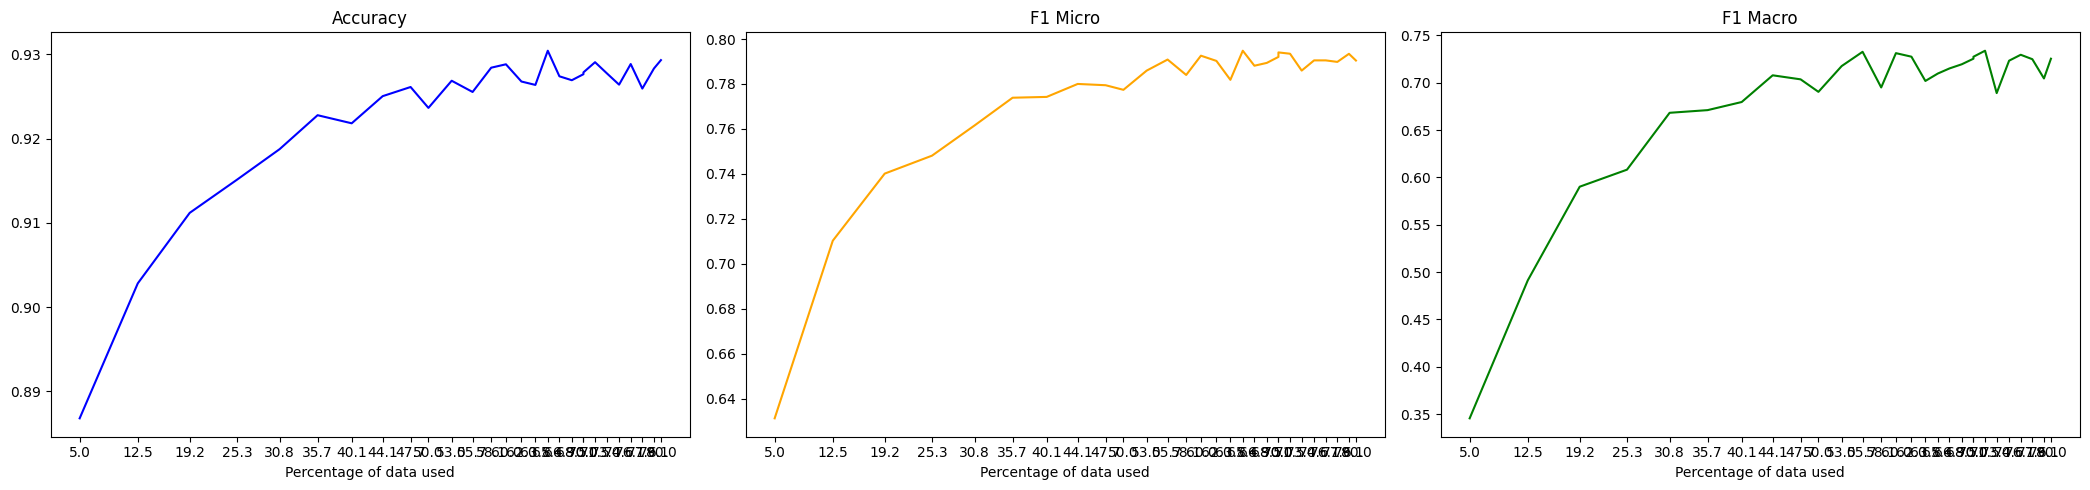

In [25]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.555, Accuracy: 0.8348, F1 Micro: 0.1412, F1 Macro: 0.0514
Epoch 2/10, Train Loss: 0.4113, Accuracy: 0.833, F1 Micro: 0.088, F1 Macro: 0.0343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3843, Accuracy: 0.85, F1 Micro: 0.3323, F1 Macro: 0.1045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3599, Accuracy: 0.8618, F1 Micro: 0.4297, F1 Macro: 0.1746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3369, Accuracy: 0.8752, F1 Micro: 0.5274, F1 Macro: 0.2436
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2854, Accuracy: 0.8782, F1 Micro: 0.5421, F1 Macro: 0.254
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2723, Accuracy: 0.8832, F1 Micro: 0.5806, F1 Macro: 0.2996
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2324, Accuracy: 0.8863, F1 Micro: 0.611, F1 Macro: 0.3353
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2048, Accuracy: 0.8859, F1 Micro: 0.6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4706, Accuracy: 0.833, F1 Micro: 0.0834, F1 Macro: 0.0336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3639, Accuracy: 0.8677, F1 Micro: 0.4813, F1 Macro: 0.1871
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.308, Accuracy: 0.8855, F1 Micro: 0.6273, F1 Macro: 0.3306
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2706, Accuracy: 0.8918, F1 Micro: 0.6344, F1 Macro: 0.4424
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2222, Accuracy: 0.8968, F1 Micro: 0.6642, F1 Macro: 0.429
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1944, Accuracy: 0.8964, F1 Micro: 0.6911, F1 Macro: 0.4419
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1675, Accuracy: 0.8983, F1 Micro: 0.709, F1 Macro: 0.5018
Epoch 8/10, Train Loss: 0.1457, Accuracy: 0.8992, F1 Micro: 0.6541, F1 Macro: 0.4746
Epoch 9/10, Train Loss: 0.1328, Accuracy: 0.9029, F1 Micro: 0.6858, F1 Macro: 0.5146
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.437, Accuracy: 0.839, F1 Micro: 0.1486, F1 Macro: 0.0556
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3388, Accuracy: 0.8802, F1 Micro: 0.5433, F1 Macro: 0.2665
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2755, Accuracy: 0.8968, F1 Micro: 0.6946, F1 Macro: 0.4637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2302, Accuracy: 0.9051, F1 Micro: 0.6965, F1 Macro: 0.4848
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1857, Accuracy: 0.9072, F1 Micro: 0.7137, F1 Macro: 0.5095
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1559, Accuracy: 0.906, F1 Micro: 0.7266, F1 Macro: 0.5154
Epoch 7/10, Train Loss: 0.1313, Accuracy: 0.9076, F1 Micro: 0.7247, F1 Macro: 0.5271
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1099, Accuracy: 0.9076, F1 Micro: 0.7349, F1 Macro: 0.5699
Epoch 9/10, Train Loss: 0.0954, Accuracy: 0.912, F1 Micro: 0.7322, F1 Macro: 0.5771
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4314, Accuracy: 0.8641, F1 Micro: 0.42, F1 Macro: 0.1507
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3142, Accuracy: 0.8942, F1 Micro: 0.6323, F1 Macro: 0.3492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2525, Accuracy: 0.904, F1 Micro: 0.6802, F1 Macro: 0.4435
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2089, Accuracy: 0.913, F1 Micro: 0.7198, F1 Macro: 0.5356
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.172, Accuracy: 0.9134, F1 Micro: 0.7445, F1 Macro: 0.5774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1405, Accuracy: 0.9109, F1 Micro: 0.7448, F1 Macro: 0.5765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1177, Accuracy: 0.9136, F1 Micro: 0.7454, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9177, F1 Micro: 0.7496, F1 Macro: 0.6096
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4194, Accuracy: 0.8729, F1 Micro: 0.6361, F1 Macro: 0.3208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3006, Accuracy: 0.9012, F1 Micro: 0.6892, F1 Macro: 0.4388
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.245, Accuracy: 0.9112, F1 Micro: 0.7319, F1 Macro: 0.5452
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1983, Accuracy: 0.9166, F1 Micro: 0.7503, F1 Macro: 0.5788
Epoch 5/10, Train Loss: 0.1589, Accuracy: 0.9162, F1 Micro: 0.7467, F1 Macro: 0.577
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9182, F1 Micro: 0.755, F1 Macro: 0.6112
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.9193, F1 Micro: 0.7502, F1 Macro: 0.6078
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9177, F1 Micro: 0.7576, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9201, F1 Micro: 0.7591, F1 Macro: 0.6314
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4135, Accuracy: 0.8842, F1 Micro: 0.6206, F1 Macro: 0.3225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2914, Accuracy: 0.9079, F1 Micro: 0.7081, F1 Macro: 0.5197
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2306, Accuracy: 0.9156, F1 Micro: 0.7472, F1 Macro: 0.581
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.918, F1 Micro: 0.7464, F1 Macro: 0.5888
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9197, F1 Micro: 0.7625, F1 Macro: 0.6132
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9185, F1 Micro: 0.7664, F1 Macro: 0.6315
Epoch 7/10, Train Loss: 0.0964, Accuracy: 0.9184, F1 Micro: 0.7637, F1 Macro: 0.6409
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.921, F1 Micro: 0.7702, F1 Macro: 0.6422
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9209, F1 Micro: 0.772, F1 Macro: 0.6661
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4056, Accuracy: 0.8817, F1 Micro: 0.5388, F1 Macro: 0.2779
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2826, Accuracy: 0.9091, F1 Micro: 0.7176, F1 Macro: 0.5344
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2326, Accuracy: 0.9157, F1 Micro: 0.7462, F1 Macro: 0.5715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1835, Accuracy: 0.9206, F1 Micro: 0.749, F1 Macro: 0.583
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1548, Accuracy: 0.9168, F1 Micro: 0.7643, F1 Macro: 0.6408
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1269, Accuracy: 0.9231, F1 Micro: 0.7734, F1 Macro: 0.6477
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9254, F1 Micro: 0.7747, F1 Macro: 0.6565
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9227, F1 Micro: 0.7716, F1 Macro: 0.6756
Epoch 9/10, Train Loss: 0.0674, Accuracy: 0.9191, F1 Micro: 0.7669, F1 Macro: 0.683
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3937, Accuracy: 0.89, F1 Micro: 0.6799, F1 Macro: 0.3986
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.283, Accuracy: 0.9097, F1 Micro: 0.7343, F1 Macro: 0.5519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2288, Accuracy: 0.9169, F1 Micro: 0.7515, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9197, F1 Micro: 0.7614, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1443, Accuracy: 0.9185, F1 Micro: 0.7665, F1 Macro: 0.629
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9229, F1 Micro: 0.7738, F1 Macro: 0.6694
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9242, F1 Micro: 0.7692, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9234, F1 Micro: 0.7801, F1 Macro: 0.6925
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9239, F1 Micro: 0.7762, F1 Macro: 0.6838
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3885, Accuracy: 0.897, F1 Micro: 0.6548, F1 Macro: 0.4475
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2703, Accuracy: 0.914, F1 Micro: 0.7258, F1 Macro: 0.5608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2157, Accuracy: 0.9187, F1 Micro: 0.7648, F1 Macro: 0.5929
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9246, F1 Micro: 0.768, F1 Macro: 0.6308
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9223, F1 Micro: 0.7708, F1 Macro: 0.6436
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.925, F1 Micro: 0.7755, F1 Macro: 0.6542
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0933, Accuracy: 0.9252, F1 Micro: 0.7808, F1 Macro: 0.66
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.9254, F1 Micro: 0.777, F1 Macro: 0.6833
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9261, F1 Micro: 0.78

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3911, Accuracy: 0.8949, F1 Micro: 0.6778, F1 Macro: 0.4968
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2691, Accuracy: 0.9138, F1 Micro: 0.734, F1 Macro: 0.5514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2208, Accuracy: 0.9194, F1 Micro: 0.7546, F1 Macro: 0.5843
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.9239, F1 Micro: 0.7738, F1 Macro: 0.626
Epoch 5/10, Train Loss: 0.1443, Accuracy: 0.923, F1 Micro: 0.7731, F1 Macro: 0.6403
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.119, Accuracy: 0.9257, F1 Micro: 0.7839, F1 Macro: 0.6549
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.927, F1 Micro: 0.7757, F1 Macro: 0.6778
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9225, F1 Micro: 0.7729, F1 Macro: 0.6739
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.9253, F1 Micro: 0.7757, F1 Macro: 0.6988
Epoch 10/10, Train Loss: 0.0565, Accuracy: 0.9253, F1 Micro: 0.7728, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8947, F1 Micro: 0.6857, F1 Macro: 0.3803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.9134, F1 Micro: 0.746, F1 Macro: 0.5438
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.9165, F1 Micro: 0.7633, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9252, F1 Micro: 0.7714, F1 Macro: 0.6219
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.925, F1 Micro: 0.77, F1 Macro: 0.666
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9243, F1 Micro: 0.7669, F1 Macro: 0.6819
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0856, Accuracy: 0.923, F1 Micro: 0.7813, F1 Macro: 0.678
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9247, F1 Micro: 0.7823, F1 Macro: 0.7011
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9224, F1 Micro: 0.7733, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.378, Accuracy: 0.8997, F1 Micro: 0.6966, F1 Macro: 0.4802
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.9173, F1 Micro: 0.7409, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2132, Accuracy: 0.919, F1 Micro: 0.7658, F1 Macro: 0.6049
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9229, F1 Micro: 0.7778, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.9262, F1 Micro: 0.7828, F1 Macro: 0.6527
Epoch 6/10, Train Loss: 0.1076, Accuracy: 0.9247, F1 Micro: 0.774, F1 Macro: 0.6573
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.9217, F1 Micro: 0.7779, F1 Macro: 0.6996
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9251, F1 Micro: 0.7791, F1 Macro: 0.6995
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.925, F1 Micro: 0.7806, F1 Macro: 0.714
Epoch 10/10, Train Loss: 0.0568, Accuracy: 0.9275, F1 Micro: 0.7764, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3754, Accuracy: 0.9016, F1 Micro: 0.6846, F1 Macro: 0.4702
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2615, Accuracy: 0.9149, F1 Micro: 0.7336, F1 Macro: 0.5533
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2116, Accuracy: 0.9223, F1 Micro: 0.7681, F1 Macro: 0.6161
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9249, F1 Micro: 0.7797, F1 Macro: 0.6565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9281, F1 Micro: 0.7817, F1 Macro: 0.6609
Epoch 6/10, Train Loss: 0.1063, Accuracy: 0.9256, F1 Micro: 0.7794, F1 Macro: 0.6846
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.9271, F1 Micro: 0.7827, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9257, F1 Micro: 0.7861, F1 Macro: 0.7021
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9264, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3714, Accuracy: 0.8934, F1 Micro: 0.6992, F1 Macro: 0.4476
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.9185, F1 Micro: 0.7402, F1 Macro: 0.5739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.9193, F1 Micro: 0.7715, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9269, F1 Micro: 0.7797, F1 Macro: 0.6524
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9265, F1 Micro: 0.7788, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.9271, F1 Micro: 0.7812, F1 Macro: 0.6963
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9259, F1 Micro: 0.7827, F1 Macro: 0.7019
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9254, F1 Micro: 0.7884, F1 Macro: 0.7203
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9259, F1 Micro: 0.7849, F1 Macro: 0.7196
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3719, Accuracy: 0.8971, F1 Micro: 0.6218, F1 Macro: 0.3736
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9174, F1 Micro: 0.7386, F1 Macro: 0.5547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.9244, F1 Micro: 0.7676, F1 Macro: 0.6244
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9259, F1 Micro: 0.7816, F1 Macro: 0.6819
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.9251, F1 Micro: 0.785, F1 Macro: 0.6978
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.9285, F1 Micro: 0.7877, F1 Macro: 0.7055
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9274, F1 Micro: 0.7793, F1 Macro: 0.6966
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9265, F1 Micro: 0.7855, F1 Macro: 0.7123
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9261, F1 Micro: 0.7859, F1 Macro: 0.7195
Epoch 10/10, Train Loss: 0.0507, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3674, Accuracy: 0.9019, F1 Micro: 0.7051, F1 Macro: 0.462
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2516, Accuracy: 0.9161, F1 Micro: 0.7336, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.199, Accuracy: 0.923, F1 Micro: 0.7687, F1 Macro: 0.6231
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9274, F1 Micro: 0.7835, F1 Macro: 0.6656
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9249, F1 Micro: 0.7758, F1 Macro: 0.6744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.9275, F1 Micro: 0.7866, F1 Macro: 0.6869
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9245, F1 Micro: 0.7867, F1 Macro: 0.7029
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9285, F1 Micro: 0.7884, F1 Macro: 0.7248
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9293, F1 Micro: 0.7878, F1 Macro: 0.7207
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3639, Accuracy: 0.9029, F1 Micro: 0.7034, F1 Macro: 0.4809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.9132, F1 Micro: 0.7599, F1 Macro: 0.6036
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.9203, F1 Micro: 0.7752, F1 Macro: 0.6467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9271, F1 Micro: 0.783, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.927, F1 Micro: 0.784, F1 Macro: 0.6725
Epoch 6/10, Train Loss: 0.1013, Accuracy: 0.9271, F1 Micro: 0.7758, F1 Macro: 0.6829
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9263, F1 Micro: 0.785, F1 Macro: 0.7096
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.9271, F1 Micro: 0.7791, F1 Macro: 0.7144
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.928, F1 Micro: 0.7879, F1 Macro: 0.7228
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3611, Accuracy: 0.8996, F1 Micro: 0.7162, F1 Macro: 0.5284
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2532, Accuracy: 0.9197, F1 Micro: 0.7602, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1967, Accuracy: 0.9251, F1 Micro: 0.7693, F1 Macro: 0.6368
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9259, F1 Micro: 0.7789, F1 Macro: 0.6652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9259, F1 Micro: 0.7853, F1 Macro: 0.663
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.9261, F1 Micro: 0.7836, F1 Macro: 0.7088
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.928, F1 Micro: 0.7782, F1 Macro: 0.7013
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9268, F1 Micro: 0.7863, F1 Macro: 0.7199
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.9271, F1 Micro: 0.7873, F1 Macro: 0.7197
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3567, Accuracy: 0.9037, F1 Micro: 0.6993, F1 Macro: 0.4503
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2463, Accuracy: 0.9133, F1 Micro: 0.7571, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.9256, F1 Micro: 0.7809, F1 Macro: 0.6445
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9286, F1 Micro: 0.7888, F1 Macro: 0.6681
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9252, F1 Micro: 0.7811, F1 Macro: 0.6895
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.927, F1 Micro: 0.7863, F1 Macro: 0.7064
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9256, F1 Micro: 0.7868, F1 Macro: 0.707
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9288, F1 Micro: 0.7864, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.928, F1 Micro: 0.7889, F1 Macro: 0.7244
Epoch 10/10, Train Loss: 0.0462, Accuracy: 0.9261, F1 Micro: 0.7869, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3551, Accuracy: 0.9062, F1 Micro: 0.6989, F1 Macro: 0.4853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2434, Accuracy: 0.9178, F1 Micro: 0.7377, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.9232, F1 Micro: 0.7675, F1 Macro: 0.6122
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1551, Accuracy: 0.9212, F1 Micro: 0.7778, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9269, F1 Micro: 0.7856, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9265, F1 Micro: 0.788, F1 Macro: 0.7082
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9269, F1 Micro: 0.7832, F1 Macro: 0.702
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9282, F1 Micro: 0.7904, F1 Macro: 0.7244
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9266, F1 Micro: 0.778, F1 Macro: 0.7151
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3495, Accuracy: 0.906, F1 Micro: 0.693, F1 Macro: 0.4841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2415, Accuracy: 0.916, F1 Micro: 0.7561, F1 Macro: 0.5706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1912, Accuracy: 0.9261, F1 Micro: 0.7749, F1 Macro: 0.63
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.927, F1 Micro: 0.7819, F1 Macro: 0.6751
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9255, F1 Micro: 0.7801, F1 Macro: 0.6785
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.928, F1 Micro: 0.79, F1 Macro: 0.7167
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9292, F1 Micro: 0.7894, F1 Macro: 0.7058
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9267, F1 Micro: 0.7855, F1 Macro: 0.7128
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9279, F1 Micro: 0.7928, F1 Macro: 0.7252
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3525, Accuracy: 0.9035, F1 Micro: 0.6752, F1 Macro: 0.4267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2373, Accuracy: 0.9171, F1 Micro: 0.7541, F1 Macro: 0.5781
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.9246, F1 Micro: 0.7719, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9252, F1 Micro: 0.7789, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9271, F1 Micro: 0.7836, F1 Macro: 0.6927
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9287, F1 Micro: 0.7916, F1 Macro: 0.7141
Epoch 7/10, Train Loss: 0.0826, Accuracy: 0.9261, F1 Micro: 0.7842, F1 Macro: 0.7166
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9258, F1 Micro: 0.7731, F1 Macro: 0.7085
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.921, F1 Micro: 0.7835, F1 Macro: 0.7165
Epoch 10/10, Train Loss: 0.0475, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3415, Accuracy: 0.9024, F1 Micro: 0.7221, F1 Macro: 0.5027
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2306, Accuracy: 0.9155, F1 Micro: 0.7623, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1867, Accuracy: 0.9255, F1 Micro: 0.7822, F1 Macro: 0.6408
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9265, F1 Micro: 0.7791, F1 Macro: 0.6765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9251, F1 Micro: 0.7867, F1 Macro: 0.7043
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9255, F1 Micro: 0.7797, F1 Macro: 0.7004
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9256, F1 Micro: 0.7856, F1 Macro: 0.7161
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9282, F1 Micro: 0.785, F1 Macro: 0.7201
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9268, F1 Micro: 0.7866, F1 Macro: 0.7184
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.9258, F1 Micro: 0.78, F1 Macro: 0.7189

 Iteration 9618: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3452, Accuracy: 0.9054, F1 Micro: 0.6972, F1 Macro: 0.5051
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2285, Accuracy: 0.9192, F1 Micro: 0.7393, F1 Macro: 0.5827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1798, Accuracy: 0.9262, F1 Micro: 0.7755, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9296, F1 Micro: 0.7902, F1 Macro: 0.6881
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.9252, F1 Micro: 0.7862, F1 Macro: 0.699
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9286, F1 Micro: 0.7858, F1 Macro: 0.6926
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9274, F1 Micro: 0.79, F1 Macro: 0.718
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.927, F1 Micro: 0.7826, F1 Macro: 0.7122
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9269, F1 Micro: 0.7849, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.9281, F1 Micro: 0.7925, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3385, Accuracy: 0.9027, F1 Micro: 0.6715, F1 Macro: 0.4385
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2253, Accuracy: 0.9175, F1 Micro: 0.7614, F1 Macro: 0.5991
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1811, Accuracy: 0.9254, F1 Micro: 0.7627, F1 Macro: 0.6232
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1423, Accuracy: 0.9273, F1 Micro: 0.779, F1 Macro: 0.6667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9297, F1 Micro: 0.7859, F1 Macro: 0.6676
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9229, F1 Micro: 0.7822, F1 Macro: 0.7114
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.926, F1 Micro: 0.7875, F1 Macro: 0.7149
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.9283, F1 Micro: 0.7881, F1 Macro: 0.7164
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9227, F1 Micro: 0.7809, F1 Macro: 0.7142
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.332, Accuracy: 0.9065, F1 Micro: 0.7056, F1 Macro: 0.4951
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2244, Accuracy: 0.9196, F1 Micro: 0.7529, F1 Macro: 0.5614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.175, Accuracy: 0.9245, F1 Micro: 0.7822, F1 Macro: 0.6609
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9275, F1 Micro: 0.7798, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.9288, F1 Micro: 0.786, F1 Macro: 0.6703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9292, F1 Micro: 0.7905, F1 Macro: 0.6944
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9287, F1 Micro: 0.7852, F1 Macro: 0.7076
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9229, F1 Micro: 0.7845, F1 Macro: 0.7143
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9283, F1 Micro: 0.7885, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0445, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3318, Accuracy: 0.9043, F1 Micro: 0.6965, F1 Macro: 0.4526
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2184, Accuracy: 0.9205, F1 Micro: 0.7544, F1 Macro: 0.576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.9222, F1 Micro: 0.7753, F1 Macro: 0.632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1385, Accuracy: 0.9265, F1 Micro: 0.7871, F1 Macro: 0.6828
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9259, F1 Micro: 0.7831, F1 Macro: 0.698
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.9271, F1 Micro: 0.7837, F1 Macro: 0.7024
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9241, F1 Micro: 0.7765, F1 Macro: 0.6938
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9287, F1 Micro: 0.7875, F1 Macro: 0.7052
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.928, F1 Micro: 0.7915, F1 Macro: 0.7268
Epoch 10/10, Train Loss: 0.0404, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3278, Accuracy: 0.9039, F1 Micro: 0.7165, F1 Macro: 0.5198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2147, Accuracy: 0.9206, F1 Micro: 0.7562, F1 Macro: 0.5689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9258, F1 Micro: 0.7694, F1 Macro: 0.6188
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1371, Accuracy: 0.9273, F1 Micro: 0.7847, F1 Macro: 0.6735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1078, Accuracy: 0.9288, F1 Micro: 0.7871, F1 Macro: 0.6634
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.9256, F1 Micro: 0.7915, F1 Macro: 0.7075
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9284, F1 Micro: 0.7911, F1 Macro: 0.7192
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.928, F1 Micro: 0.7788, F1 Macro: 0.7072
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9272, F1 Micro: 0.7872, F1 Macro: 0.7172
Epoch 10/10, Train Loss: 0.0404, Accur

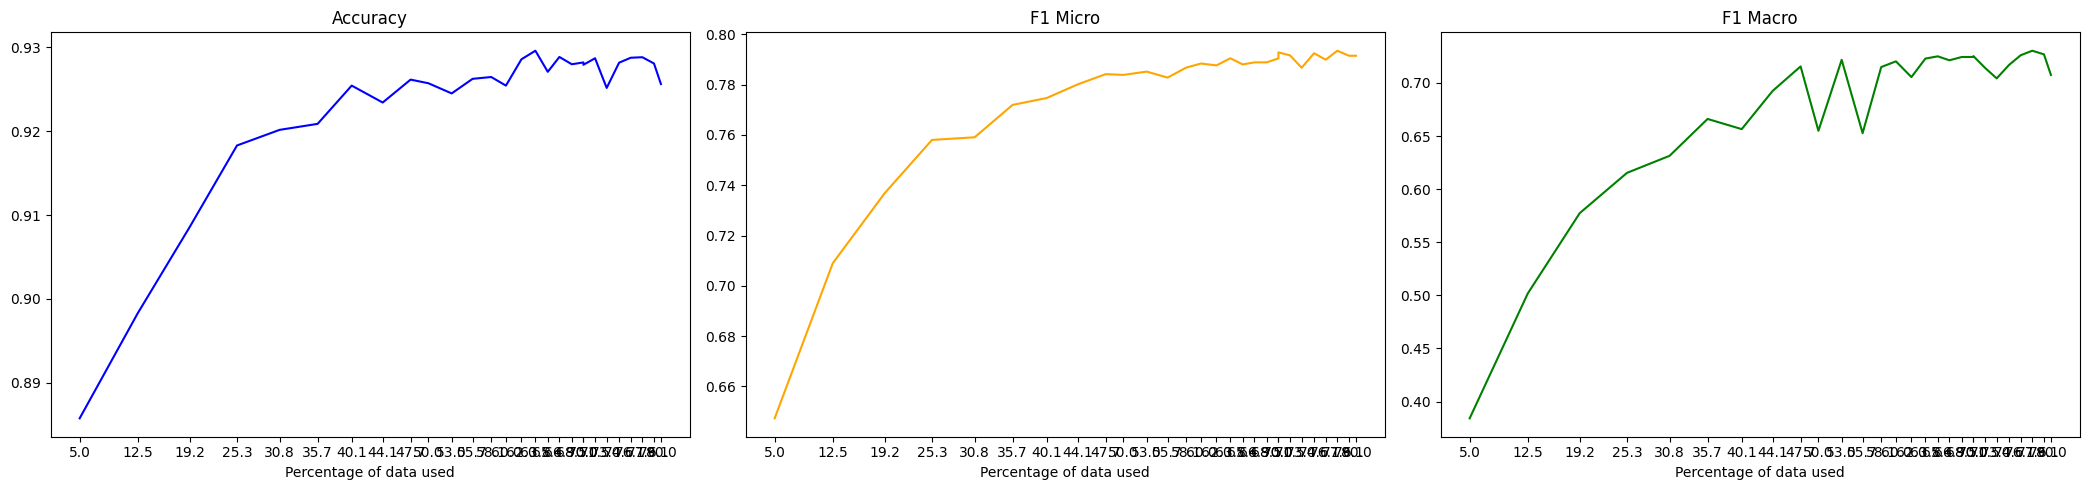

In [26]:
active_learning(seeds[4], 4)